'QTc', 'JTc', 'TpeakTend', 'TQ', 'RR'
0. RR и TQ не очень интересно. JTc и TT очень интересны. Здесь написаны все 10 наборов.
     1. (QTc, TT, JTc)
     2. (QTc, TT, TQ)
     3. (QTc, RR, TT)
     4. (QTc, RR, JTc)
     5. (QTc, TQ, JTc)
     6. (QTc, RR, TQ)
     7. (JTc, RR, TQ)
     8. (TT, RR, TQ)
     9. (RR, TT, JTc)
     10. (TQ, TT, JTc)
         
1. построить максимально много графиков. Сбалансированных. В случае первых двух случаев таблицы для II и III групп приводились по объему к первой. В случае 3 таблица для III группы приводилась к таблице II группы. При этом использовались коэфециенты COEF_II_to_I, COEF_III_to_I, COEF_II_to_III.
    1. I vs II
    2. I vs III
    3. II vs III
2. В итоге есть общая папка 3d_intervals_plots/, там будут храниться все папки с признаками. Теперь папки называются полным названием: три признака подряд + какие группы с какими сравниваются. Пример: QTc_TpeakTend_JTc_II&III. 

In [1]:
%reload_ext autoreload
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
from final_make_samples_and_patients_data import data_heal, data_sick, data_very_sick, \
                                    patients_mean_heal, patients_mean_sick, patients_mean_very_sick 
from make_ready_data.create_features_indeces import get_labels_and_features_indeces

plot_labels, _ = get_labels_and_features_indeces()
print(plot_labels)

TQ_manualis dropped
['QTc', 'JTc', 'TpeakTend', 'TQ', 'RR']


In [2]:
def create_or_clean_dir(new_dir_name, dir_name='.'):
    plots_dir = dir_name + '\\' + new_dir_name
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    else:
        for the_file in os.listdir(plots_dir):
            file_path = os.path.join(plots_dir, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path) # unlink (delete) the file
            except Exception:
                print("Except catched")


In [3]:
def form_thresh(vec1, vec2, vec3, STEP=0.005, n=2, p=0.005):
    vec = np.concatenate((vec1, vec2, vec3))
    n_cut = np.round(p*vec.size)
    start = np.round(vec.min(), n)
    stop = np.round(vec.max(), n)
    thr = np.arange(start, stop+STEP, STEP)
    e1=0; e2=0;
    for i in range(thr.size):
        if (vec<thr[i]).sum() >= n_cut:
            e1 = i
            break
            
    for i in range(thr.size-1, 0, -1):
        if (vec>thr[i]).sum() >= n_cut:
            e2 = i
            break

    return thr[e1:e2]


def get_vec_by_feat(data_heal, data_sick, data_very_sick, feat):
    vec_heal = data_heal[:, feat] 
    vec_sick = data_sick[:, feat] 
    vec_very_sick = data_very_sick[:, feat]     
    return vec_heal, vec_sick, vec_very_sick

def form_lists_for_plots(v, thresholds_space, WIN_SIZE=92):
    bins_size = thresholds_space.size - 1 
    list_bins = [None] * bins_size
    for i in range(bins_size):
        e1 = thresholds_space[i]
        e2 = thresholds_space[i+1]
        list_bins[i] = np.arange(v.size)[((v>=e1) * (v<e2))].tolist()
    return list_bins

def get_mask(data, e1, e2):
    return (e2>data)*(data>=e1)
def get_indx(data, e1, e2):
    return np.arange(data.shape[0])[(e2>data)*(data>=e1)]

# Building a big plot for one group(I/II/III).
# list_bin - inds of all samples in that group for certain 
# interval of main feature (feature in name of big plot).
# m1 and m2 - are masks for each small plot.
# Returns table - all values for one group in big plot.
def form_table_for_plot(data, list_bin, threshX, threshY, feat_X, feat_Y, WIN_SIZE=92):
    sX=threshX.size-1; sY=threshY.size-1
    dataX = data[list_bin, feat_X] # data of one big plot
    dataY = data[list_bin, feat_Y]
    table = np.zeros((sX, sY))
    for i in range(sX):
        for j in range(sY):
            m1 = get_mask(dataX, threshX[i], threshX[i+1])
            m2 = get_mask(dataY, threshY[j], threshY[j+1])
            table[i, j] = (m1*m2).sum()
    return table

In [4]:
def create_tables_for_three_features(data_heal, data_sick, data_very_sick, 
                                    feat_base=0, feat_X=1, feat_Y=2, 
                                    STEP_BASE=0.05, STEP_X=0.01, STEP_Y=0.01):
    vec_heal, vec_sick, vec_very_sick = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_base)
    vec_heal_X, vec_sick_X, vec_very_sick_X = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_X)
    vec_heal_Y, vec_sick_Y, vec_very_sick_Y = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_Y)

    thresh_base = form_thresh(vec_heal, vec_sick, vec_very_sick, STEP=STEP_BASE)
    thresh_X = form_thresh(vec_heal_X, vec_sick_X, vec_very_sick_X, STEP=STEP_X)
    thresh_Y = form_thresh(vec_heal_Y, vec_sick_Y, vec_very_sick_Y, STEP=STEP_Y)
    
    list_bin_heal = form_lists_for_plots(vec_heal, thresh_base)
    list_bin_sick = form_lists_for_plots(vec_sick, thresh_base)
    list_bin_very_sick = form_lists_for_plots(vec_very_sick, thresh_base)
    
    tables_heal = np.empty((thresh_base.size-1, thresh_X.size-1, thresh_Y.size-1))
    tables_sick = np.empty((thresh_base.size-1, thresh_X.size-1, thresh_Y.size-1))
    tables_very_sick = np.empty((thresh_base.size-1, thresh_X.size-1, thresh_Y.size-1))

    for i in range(thresh_base.size-1):
        tables_heal[i] = form_table_for_plot(data_heal, list_bin_heal[i], thresh_X, thresh_Y, feat_X, feat_Y)
        tables_sick[i] = form_table_for_plot(data_sick, list_bin_sick[i], thresh_X, thresh_Y, feat_X, feat_Y)
        tables_very_sick[i] = form_table_for_plot(data_very_sick, list_bin_very_sick[i], thresh_X, thresh_Y, feat_X, feat_Y)
    
    return tables_heal, tables_sick, tables_very_sick, thresh_base, thresh_X, thresh_Y

In [5]:
def tostr(val):
    return str(np.round(val, 3))
def build_3d_intervals_plots(tables_heal, tables_sick, 
                             thresh_base, threshX, threshY, 
                             feat, featX, featY, plt_title, n_yticks=20):
    plt.style.use('ggplot')
    plots_dir = plot_labels[feat]+"_"+plot_labels[featX]+"_"+plot_labels[featY]+"_"+plt_title
    create_or_clean_dir(plots_dir)    

    pts=thresh_base; s=thresh_base.size-1; sX=threshX.size-1; sY=threshY.size-1
    plt.rcParams['figure.figsize'] = (1.5*sY, 2.3*sX)
    threshX = threshX[::-1]
    for ii in range(s):
        t1 = tables_heal[ii][::-1]
        t2 = tables_sick[ii][::-1]
        fig, ax = plt.subplots(sX, sY, sharex='col', sharey='row')
        fig.text(0.5, 0.07, plot_labels[featY], ha='center', fontsize=15)
        fig.text(0.07, 0.5, plot_labels[featX], va='center', rotation='vertical', fontsize=15)
        fig.suptitle(plt_title, y=0.95, fontsize=15)
        for i in range(sX):
            for j in range(sY):
                _ax = ax[i, j]
                plt.sca(_ax)
                l = ["" for _ in range(0, n_yticks, 5)]; l[0] = tostr(threshX[i+1]); l[-1] = tostr(threshX[i])
                _ax.set_yticklabels(l)

                if i == sX-1:
                    _ax.set_xticklabels([tostr(threshY[j]), tostr(threshY[j+1])])
                    plt.xticks([0, 1])
                else:
                    _ax.tick_params(axis='x', which='both', length=0)
                
                plt.bar([0], t2[i, j], width=0.8, color='red')
                plt.bar([1], t1[i, j], width=0.8, color='green')
                plt.ylim(ymax = n_yticks)
                plt.yticks(range(0, n_yticks, 5))
                plt.title("red:%d green:%d"%(int(np.max(t2[i,j])), int(np.max(t1[i, j]))), size=8)
        plot_name = plots_dir+"\\"+str(ii)+"_"+plot_labels[feat]+"_"+tostr(pts[ii])+"-"+tostr(pts[ii+1])+".jpg"
        plt.savefig(plot_name, bbox_inches='tight')
        plt.close()


In [6]:
def CORRECT_STEPS(feat_base, featX, featY):
    STEP_BASE=0.01; STEP_X=0.01; STEP_Y=0.01;
    if feat_base==3 or feat_base==4:
        STEP_BASE=0.05
    if featX==3 or featX==4:
        STEP_X=0.05
    if featY==3 or featY==4:
        STEP_Y=0.05
    return STEP_BASE, STEP_X, STEP_Y

In [7]:
def build_ordered_3d_intervals_plot(table_diffes, table_labels, full_plt_title, plots_dir="3d_intervals_rating_plots"):
    plot_name = plots_dir+"\\"+full_plt_title+".jpg"

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (30, 20)
    fig, ax = plt.subplots()
    plt.bar(np.arange(0, table_diffes.size), table_diffes, width=0.2, color='blue')
    plt.title(full_plt_title, fontsize=20)
    ax.set_xticklabels(table_labels)
    plt.xticks(np.arange(0, table_diffes.size), rotation=90)
    plt.yticks(np.arange(int(table_diffes.max())))
    plt.ylabel('Score of intervals combinations', fontsize=15)
    plt.savefig(plot_name, bbox_inches='tight')
    plt.show()
    plt.close()

def find_thresh_number_of_rating(table_diffes, max_number):
    for i in range(int(table_diffes.max())):
        if (table_diffes > i).sum() < max_number:
            thresh = i
            break
    return thresh

def form_3d_intervals_rating(tables_heal, tables_sick, 
                             thresh_base, threshX, threshY, 
                             feat_base, featX, featY, 
                             plt_title):
    s_base=thresh_base.size-1; sX=threshX.size-1; sY=threshY.size-1    
    table_labels = []
    table_diffes = np.zeros(tables_heal.shape)
    for ii in range(s_base):
        for i in range(sX):
            for j in range(sY):
                label = plot_labels[feat_base] + tostr(thresh_base[ii])+"-"+tostr(thresh_base[ii+1])+"_"+\
                            plot_labels[featX]+tostr(threshX[i])+"-"+tostr(threshX[i+1])+"_" + \
                            plot_labels[featY]+tostr(threshY[j])+"-"+tostr(threshY[j+1])
                table_labels.append(label)
                h = tables_heal[ii,i,j]
                s = tables_sick[ii,i,j]
                if h==0 and s==0:
                    continue
                table_diffes[ii,i,j] = abs(h-s)
    table_diffes = table_diffes.reshape((-1,))
    thr = find_thresh_number_of_rating(table_diffes, 50)
    print(thr)
    non_zero_indeces = np.arange(table_diffes.size)[table_diffes > thr]
    print(non_zero_indeces.size)
    table_diffes = table_diffes[non_zero_indeces]
    sort_indeces = np.argsort(table_diffes)
    table_diffes = table_diffes[sort_indeces]
    table_labels = list(np.array(table_labels)[non_zero_indeces][sort_indeces])
    
    build_ordered_3d_intervals_plot(table_diffes, table_labels, 
                                    plot_labels[feat_base]+"_"+plot_labels[featX]+"_"+plot_labels[featY]+"_"+plt_title)

In [8]:
def forms_final_dirs_for_features_list(data_heal, data_sick, data_very_sick, features_list, 
                                       build_plots=True, build_rating=True):
    
    
    rating_plots_dir = "3d_intervals_rating_plots"
    create_or_clean_dir(rating_plots_dir)

    for features in features_list:
        feat_base = features[0]; featX = features[1]; featY = features[2]
        print(plot_labels[feat_base], plot_labels[featX], plot_labels[featY]) 

        STEP_BASE, STEP_X, STEP_Y=CORRECT_STEPS(feat_base, featX, featY)
        tables_heal, tables_sick, tables_very_sick, thresh_base, threshX, threshY = \
                create_tables_for_three_features(data_heal, data_sick, data_very_sick, 
                                                feat_base=feat_base, feat_X=featX, feat_Y=featY, 
                                                STEP_BASE=STEP_BASE, STEP_X=STEP_X, STEP_Y=STEP_Y)

        
        def process_one_pair_of_groups(t1, t2, plt_title, n_yticks=20):
            if build_plots:
                build_3d_intervals_plots(t1, t2, thresh_base, threshX, threshY, feat_base, featX, featY, plt_title, n_yticks)
            if build_rating:
                form_3d_intervals_rating(t1, t2, thresh_base, threshX, threshY, feat_base, featX, featY, plt_title)
            print(plt_title + "is done")

        
        sumI = tables_heal.sum(); sumII = tables_sick.sum(); sumIII = tables_very_sick.sum();
        COEF_II_to_I = sumI / sumII
        COEF_III_to_I = sumI / sumIII
        COEF_II_to_III = sumIII / sumII

        process_one_pair_of_groups(tables_heal, COEF_II_to_I*tables_sick, "I&II")
        process_one_pair_of_groups(tables_heal, COEF_III_to_I*tables_very_sick, "I&III")
        process_one_pair_of_groups(COEF_II_to_III*tables_sick, tables_very_sick, "II&III", 10)

'QTc', 'JTc', 'TpeakTend', 'TQ', 'RR'
     1. (QTc, TT, JTc) + 
     2. (QTc, TT, TQ) +
     3. (QTc, RR, TT) + 
     4. (QTc, RR, JTc) + 
     5. (QTc, TQ, JTc) -
     6. (QTc, RR, TQ)  -
     7. (JTc, RR, TQ)  -
     8. (TT, RR, TQ)   -
     9. (RR, TT, JTc) + 
     10. (TQ, TT, JTc) -

QTc TQ JTc
5
45


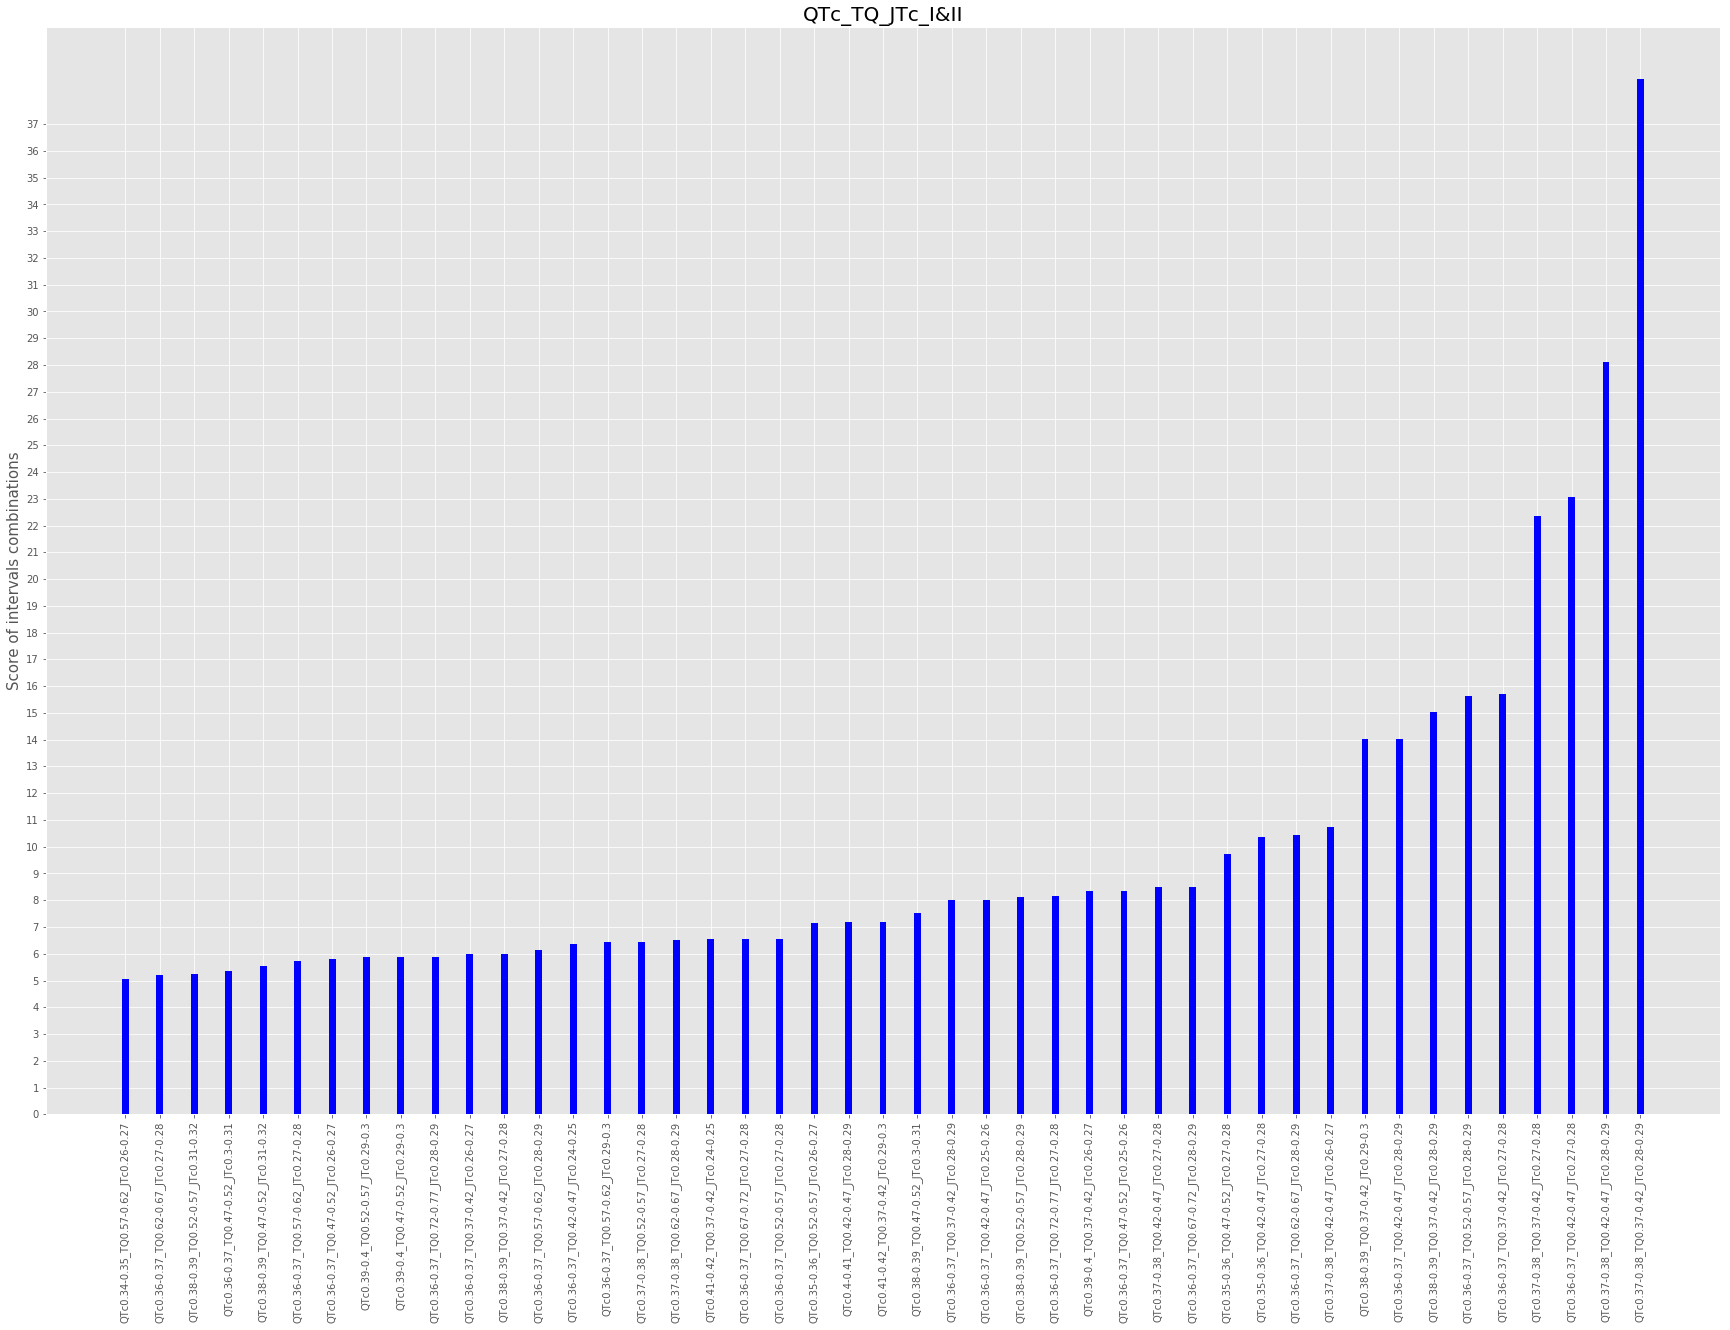

I&IIis done
12
26


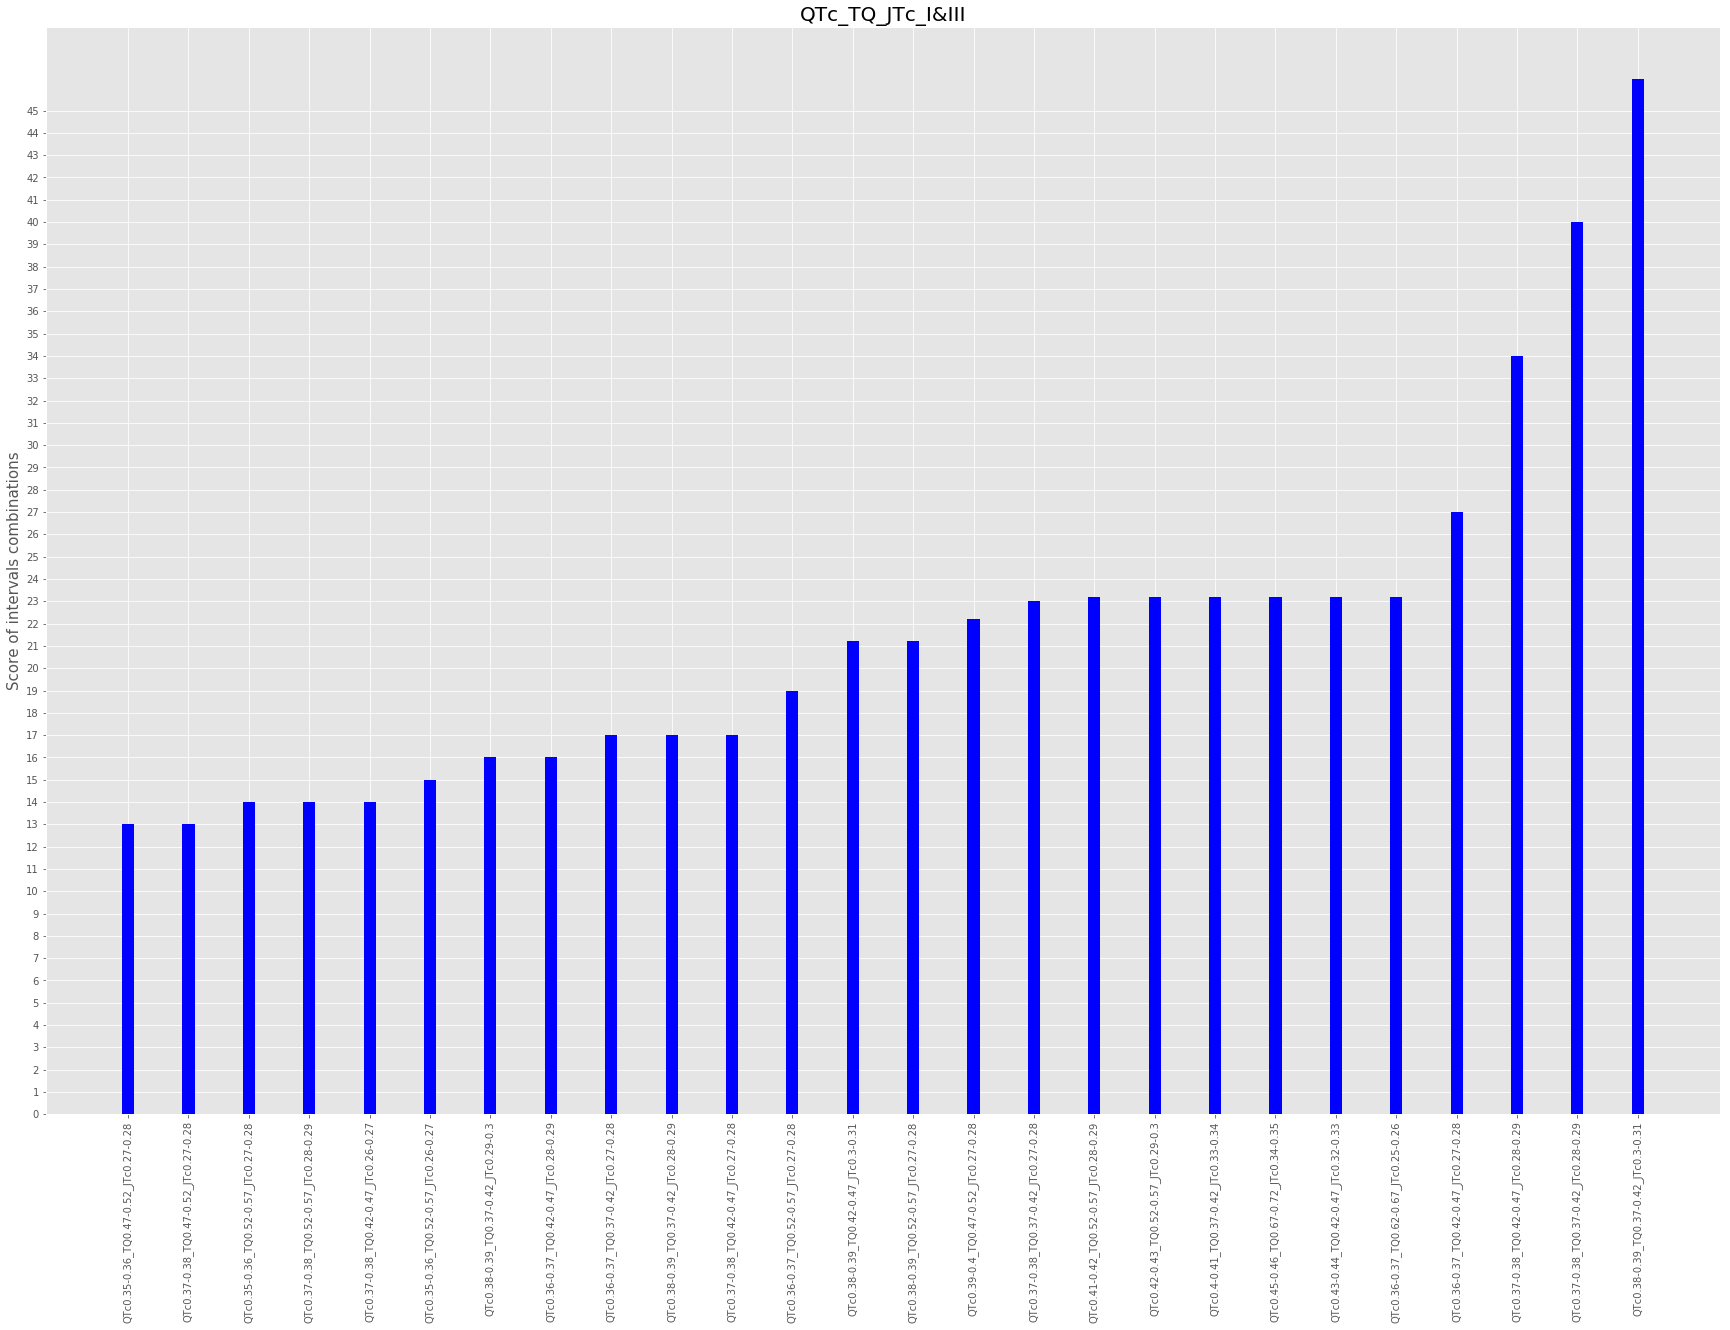

I&IIIis done
1
18


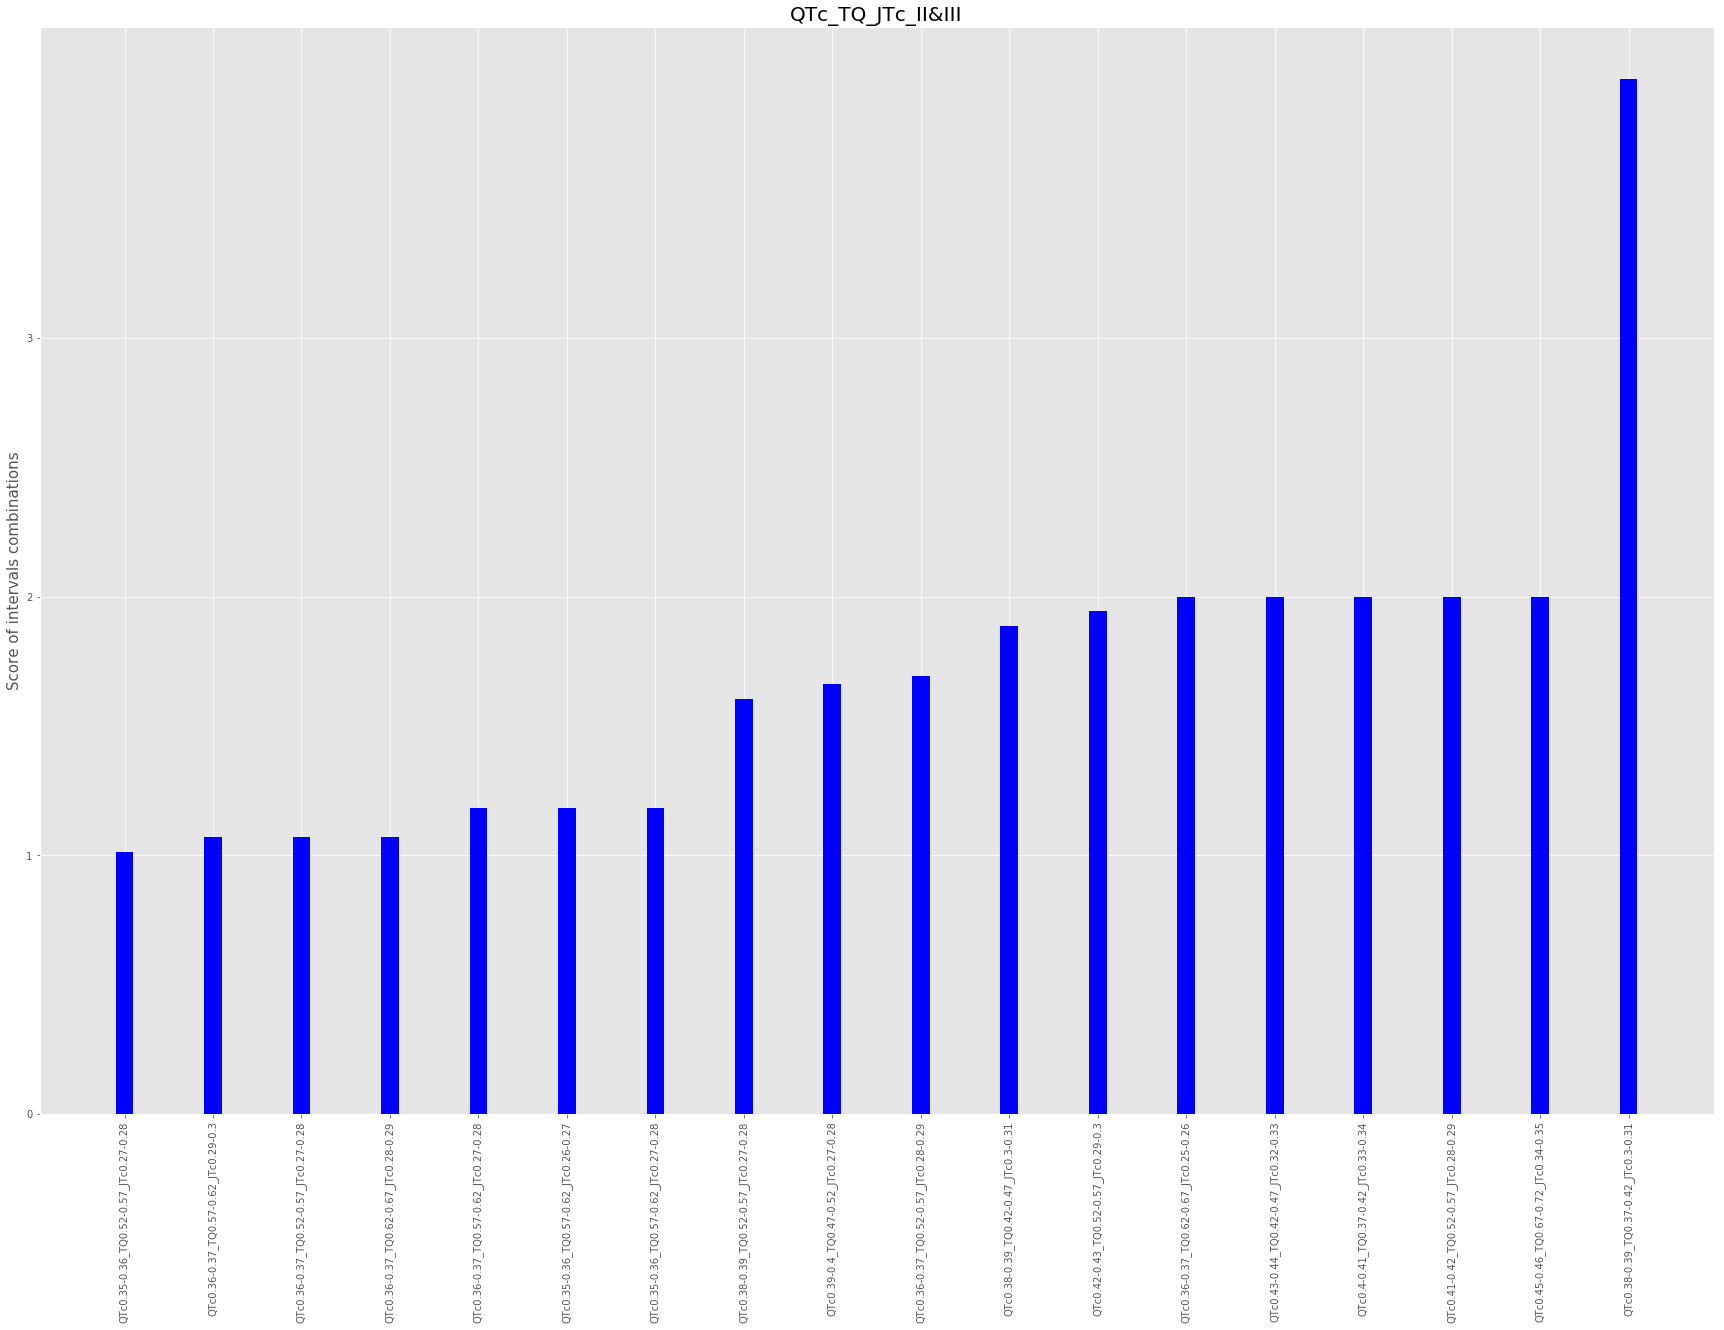

II&IIIis done
QTc RR TQ
6
44


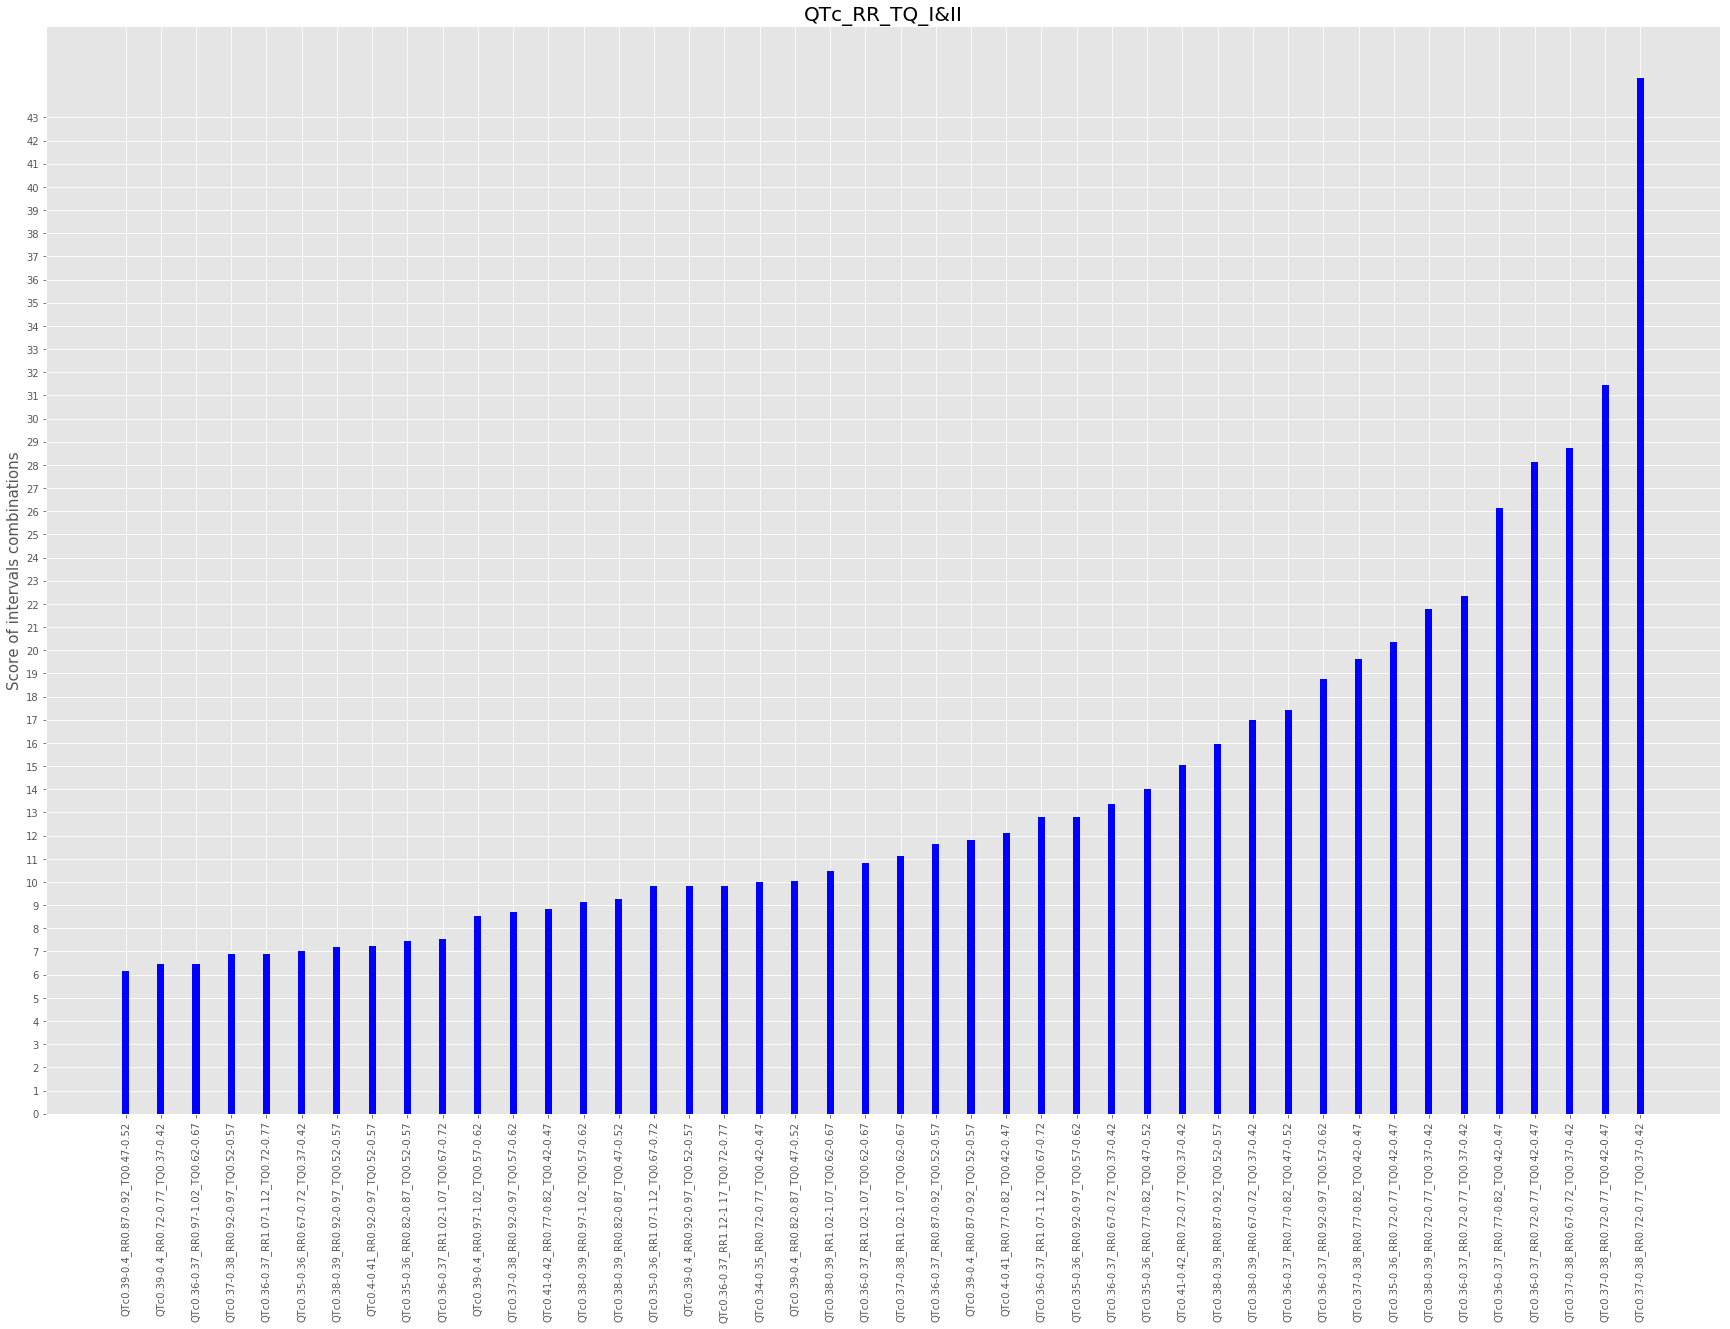

I&IIis done
13
39


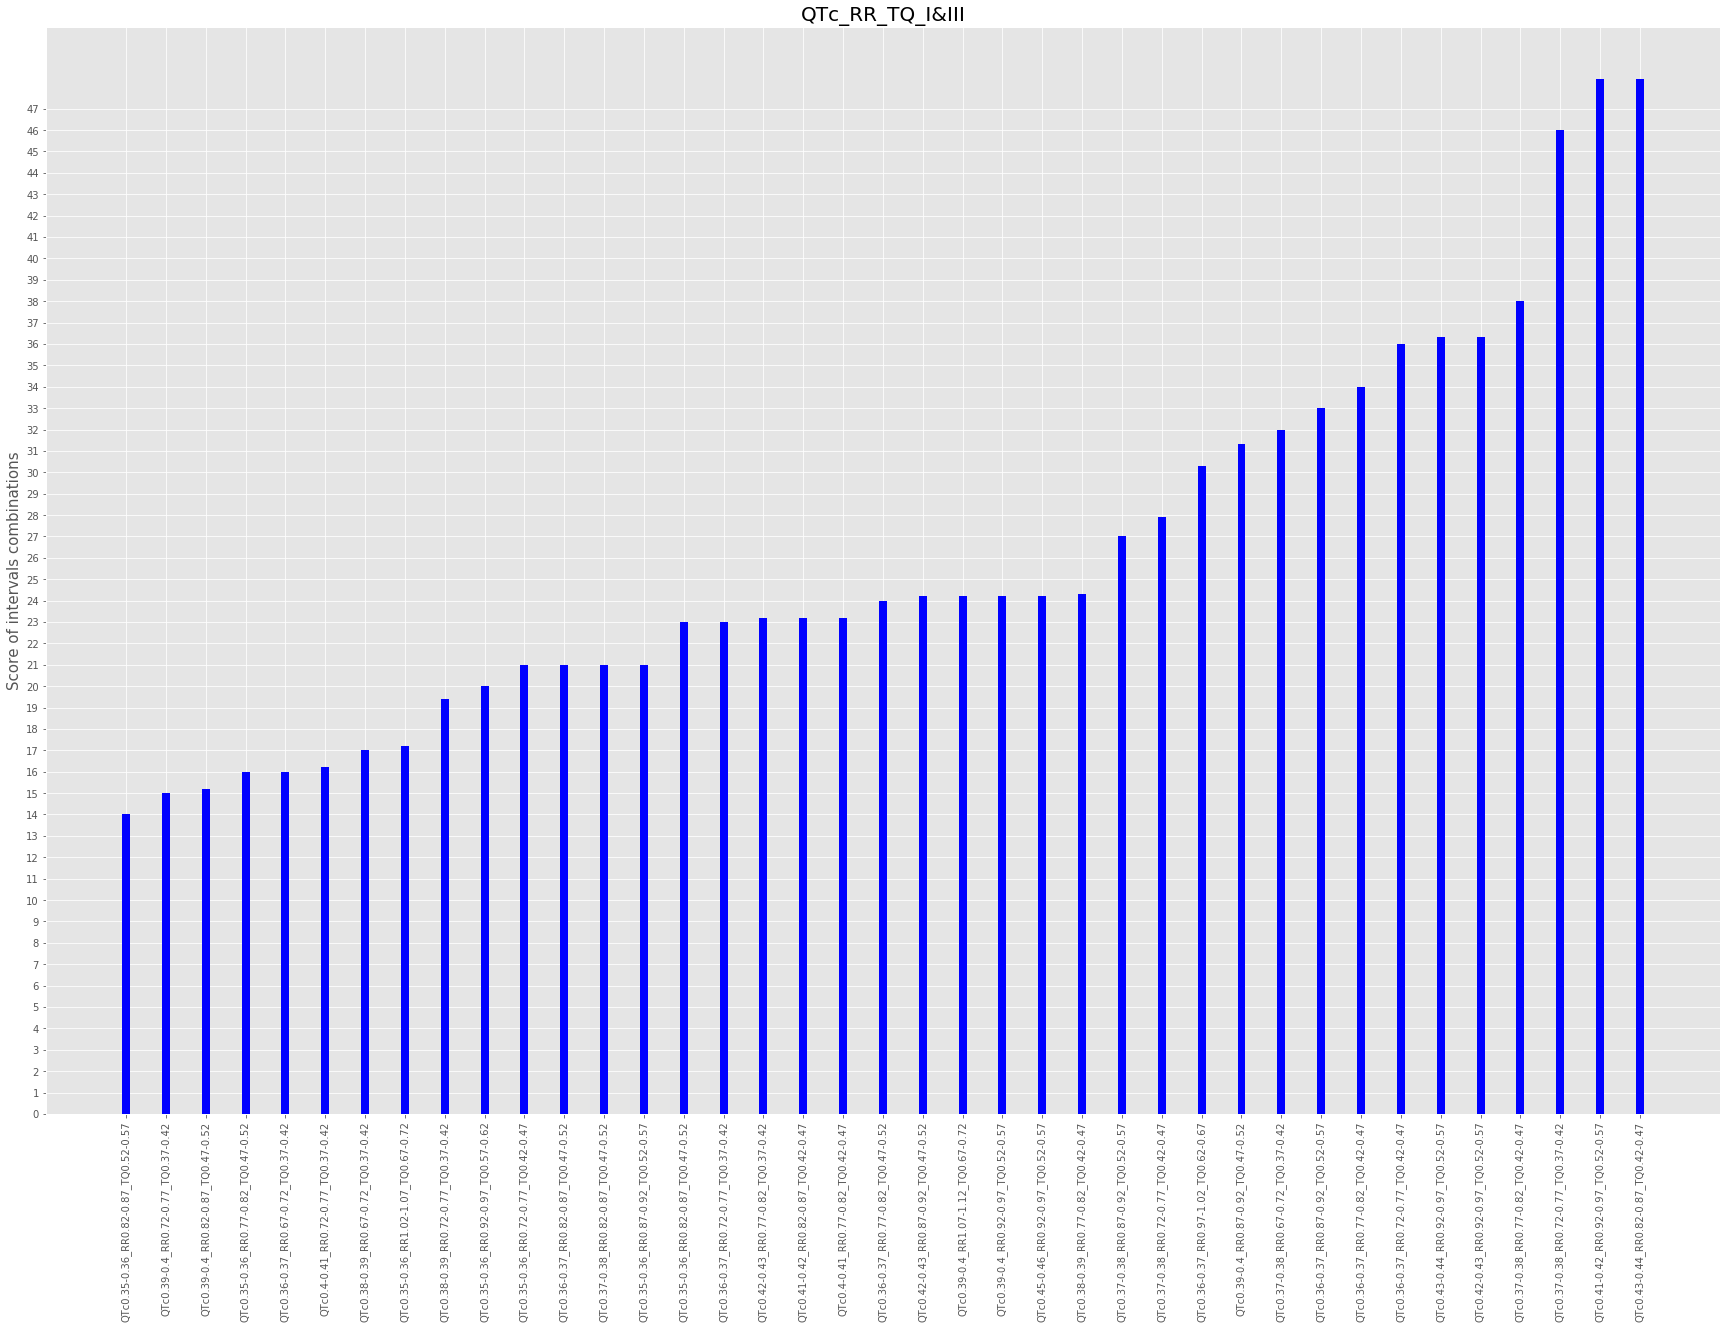

I&IIIis done
1
32


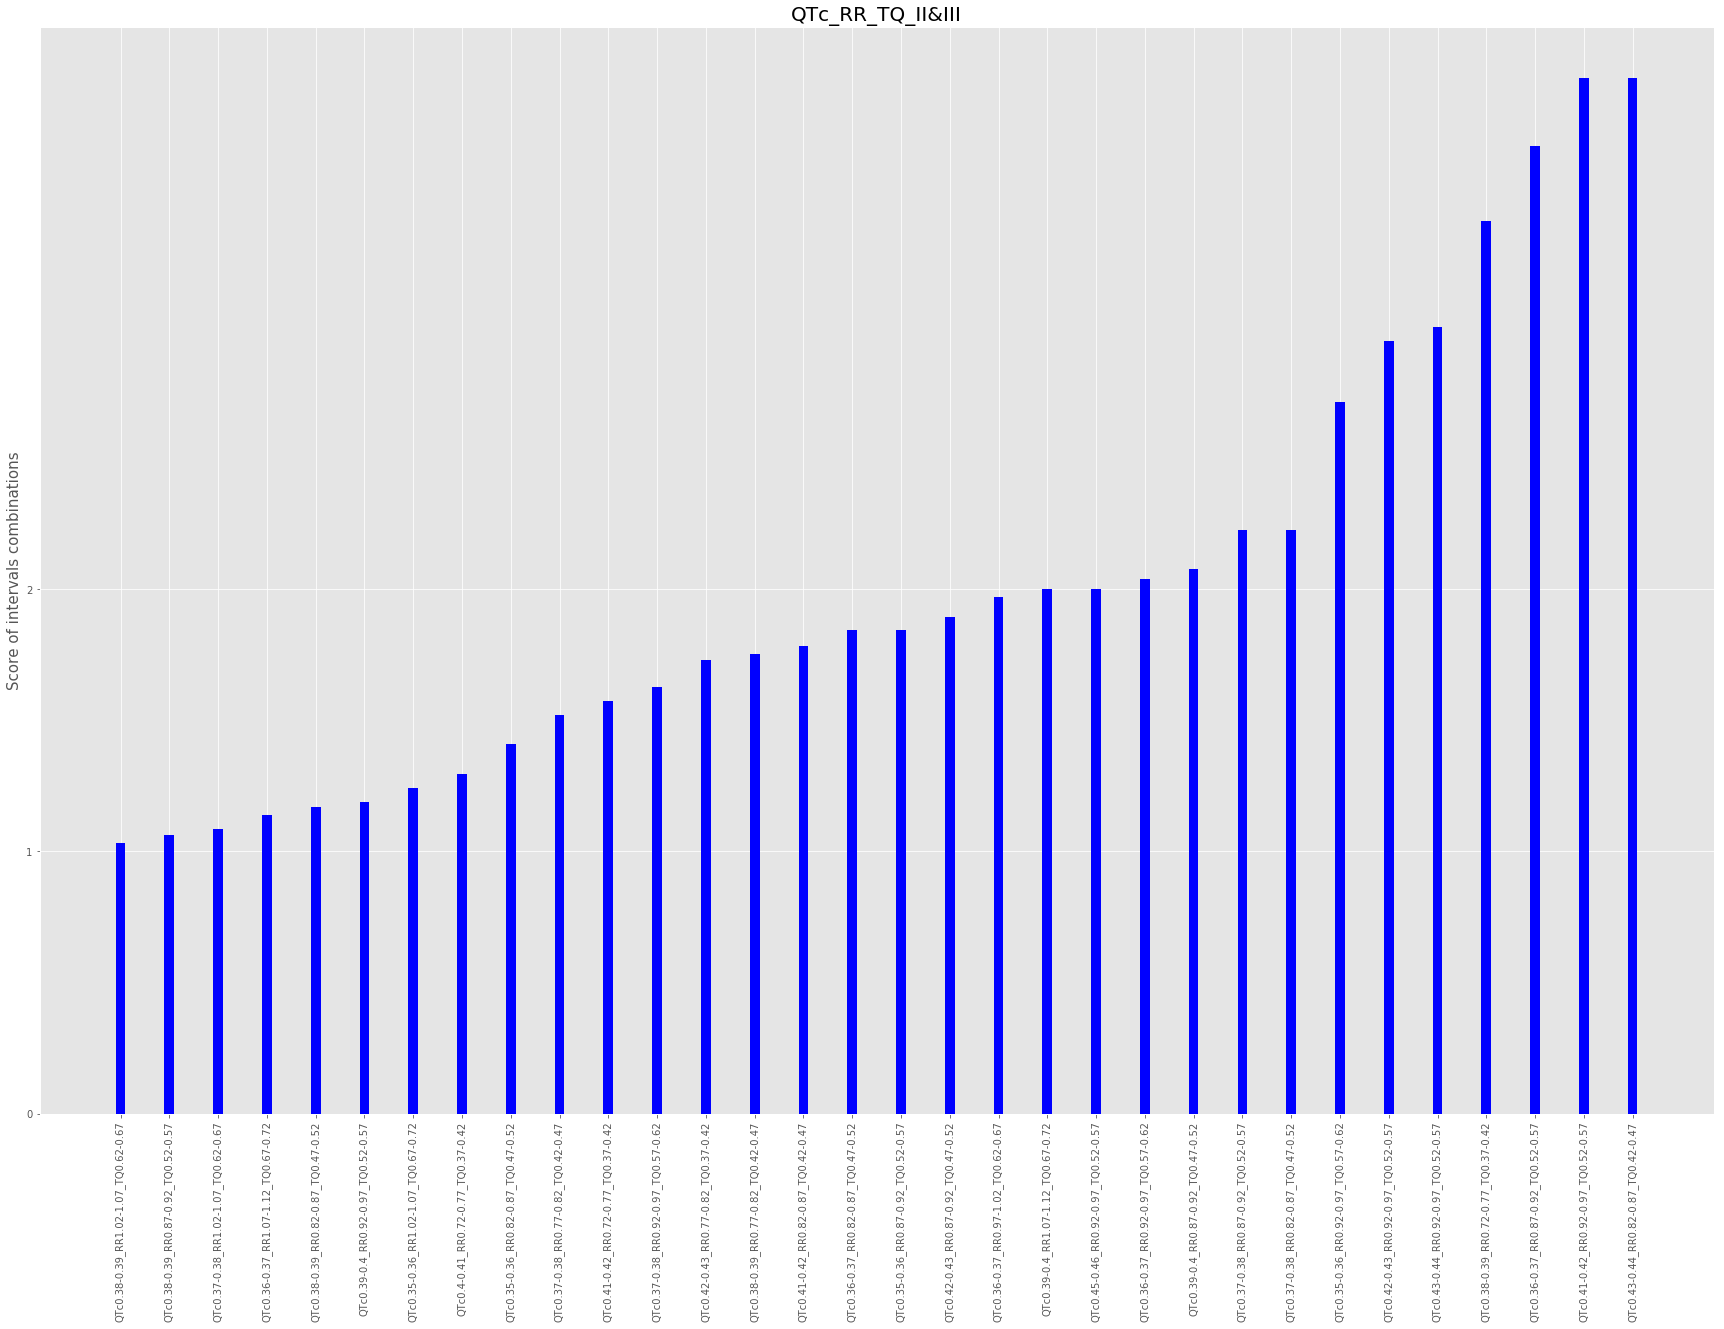

II&IIIis done
JTc RR TQ
6
37


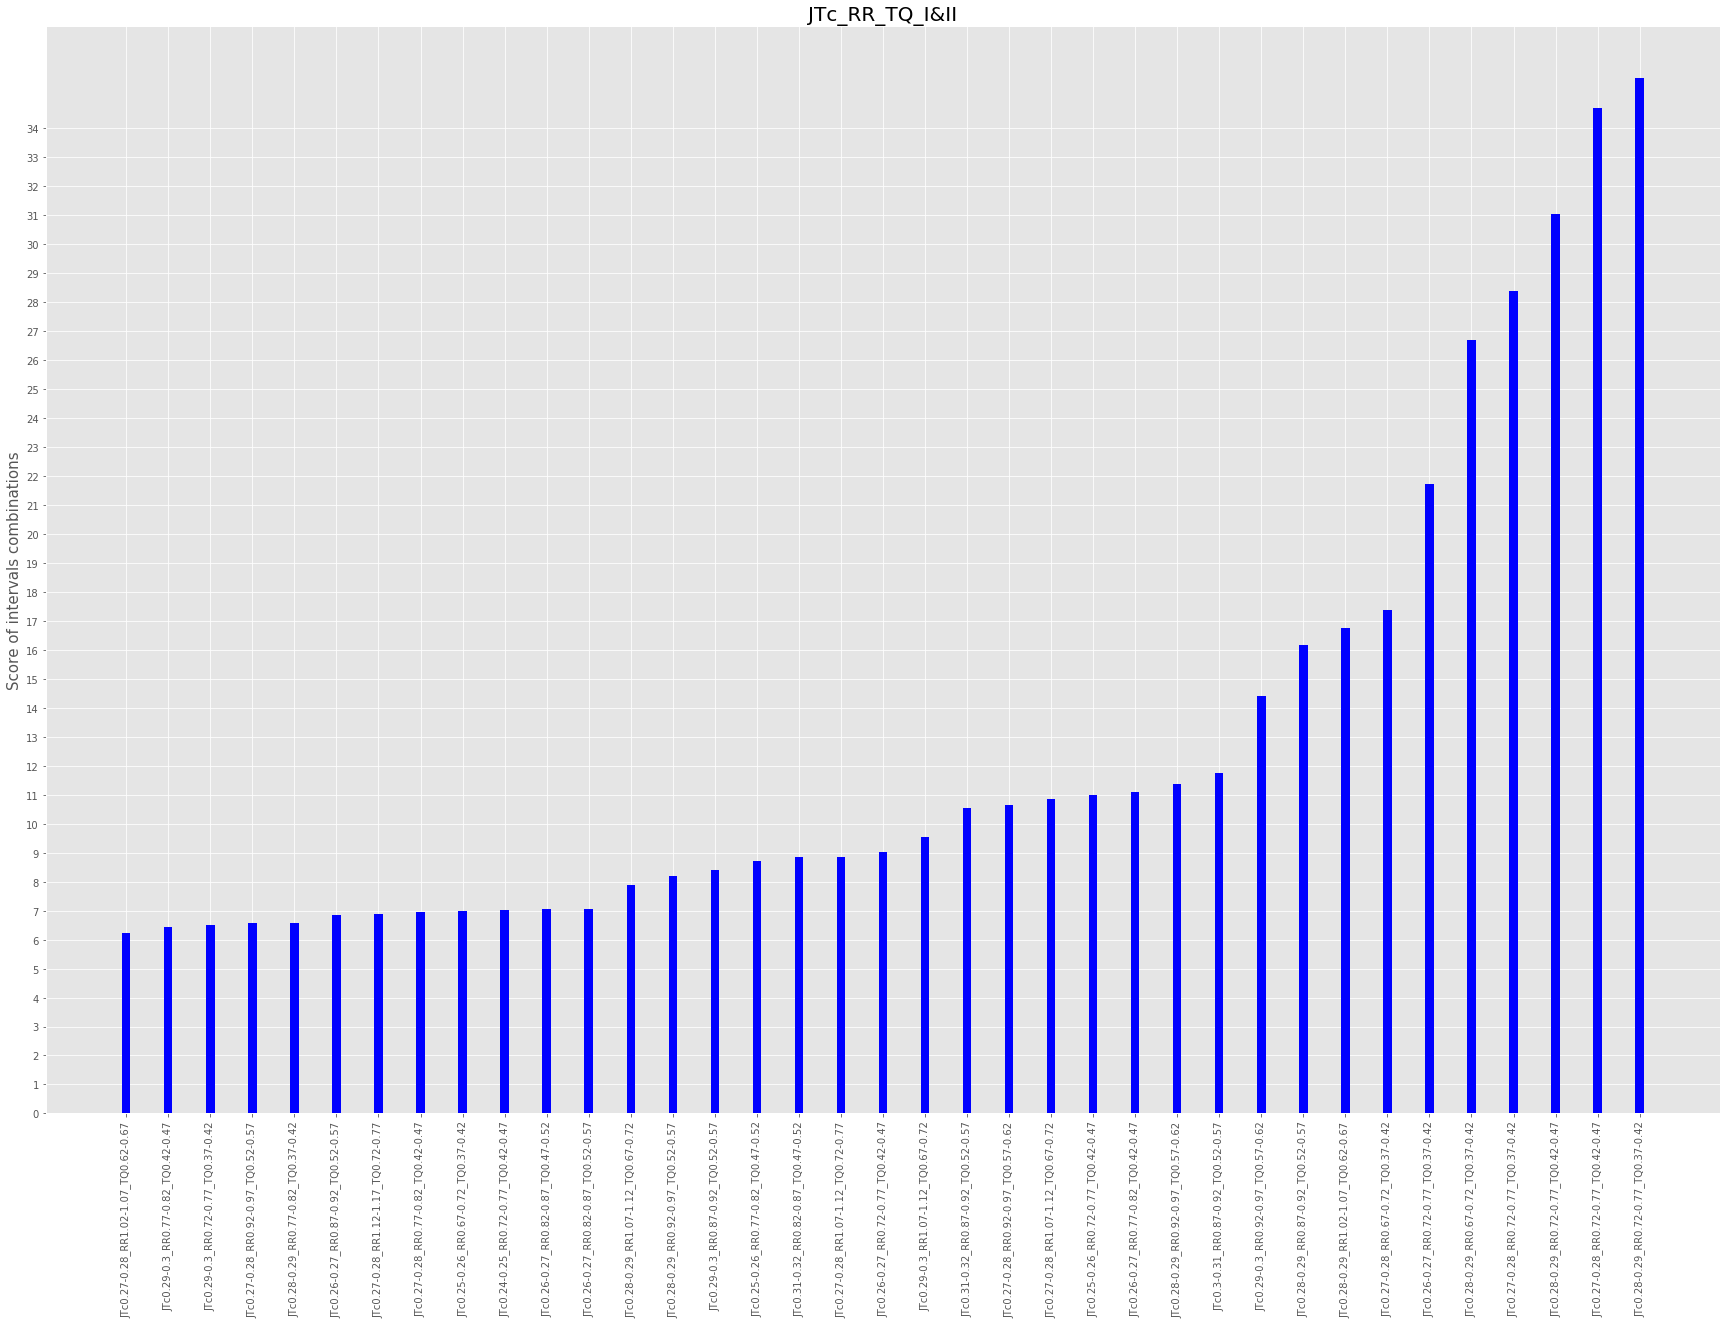

I&IIis done
12
48


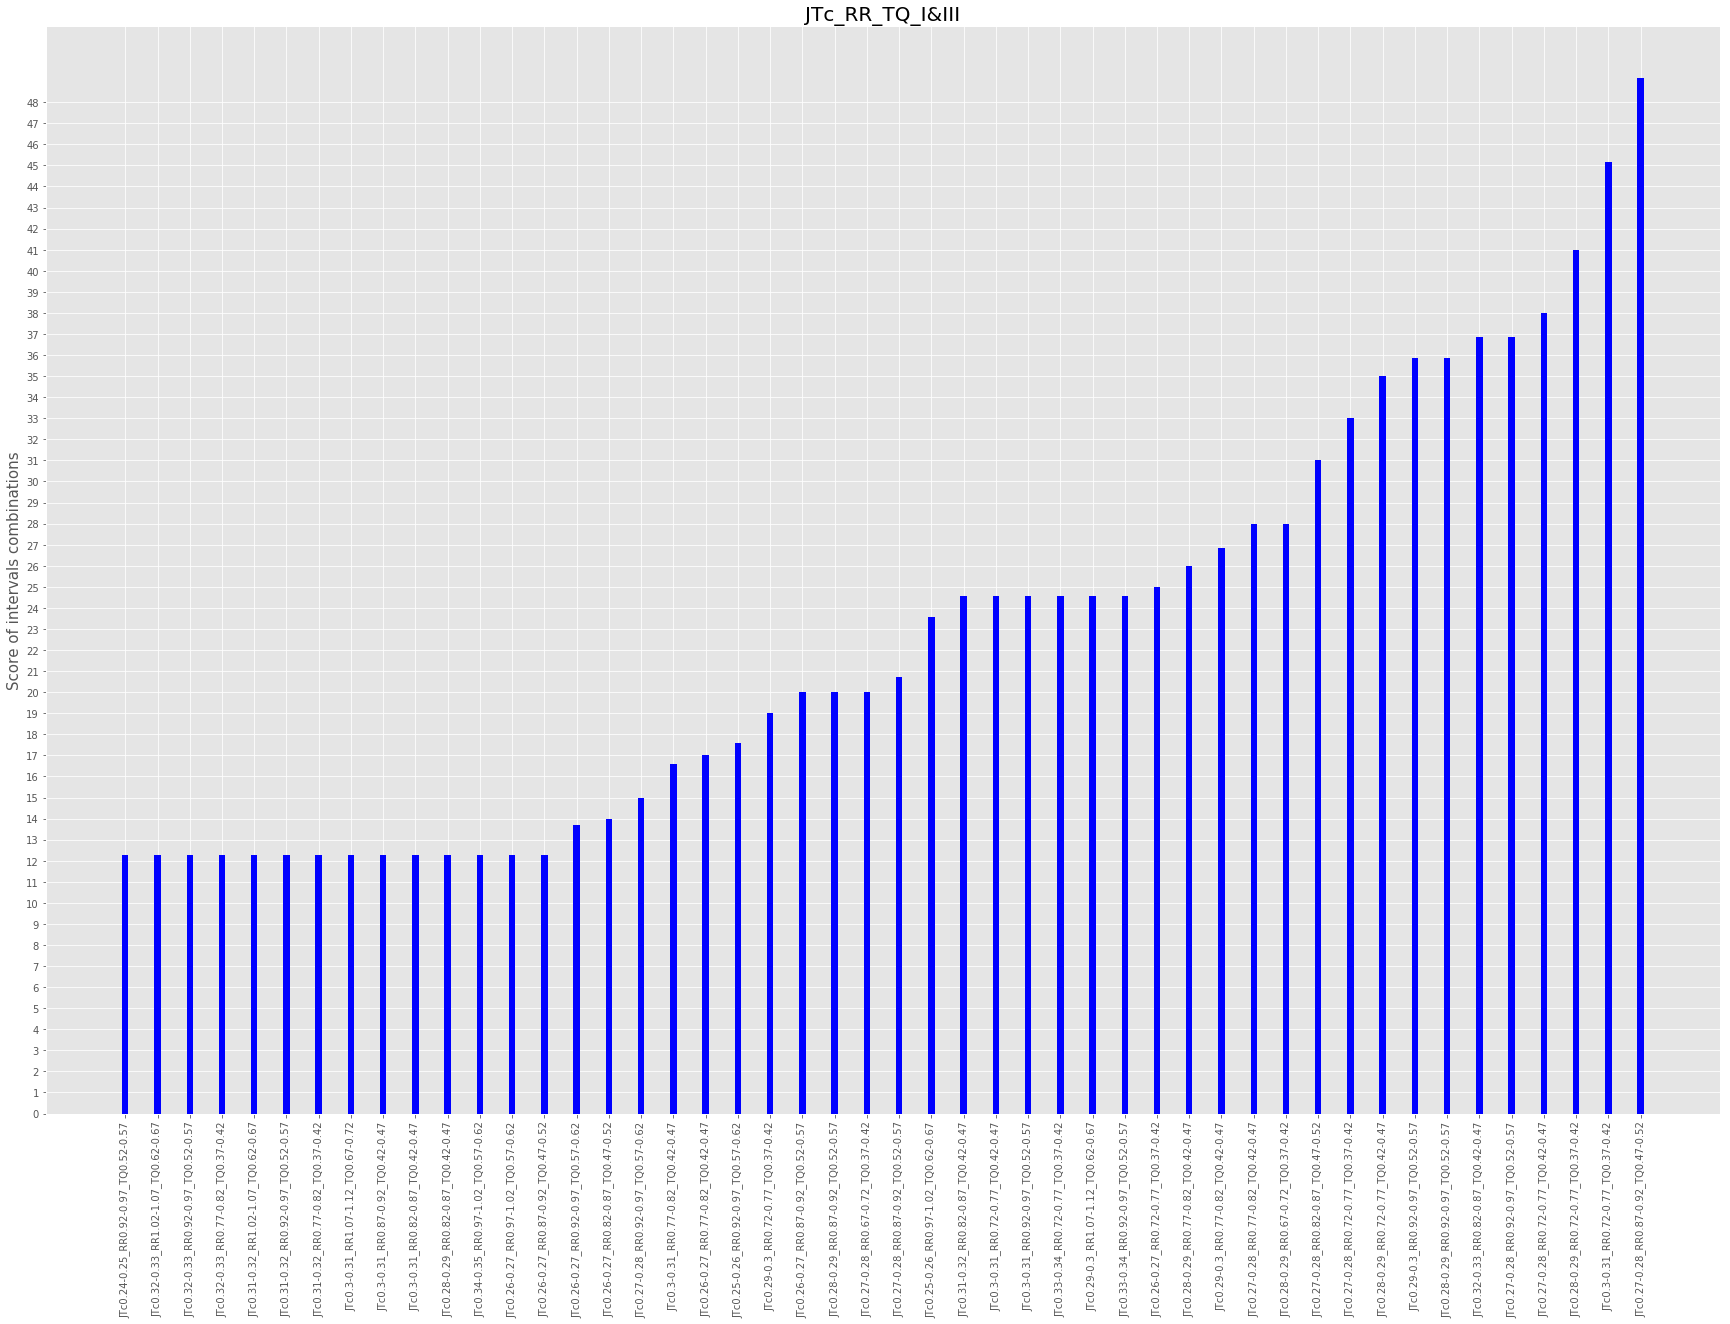

I&IIIis done
1
29


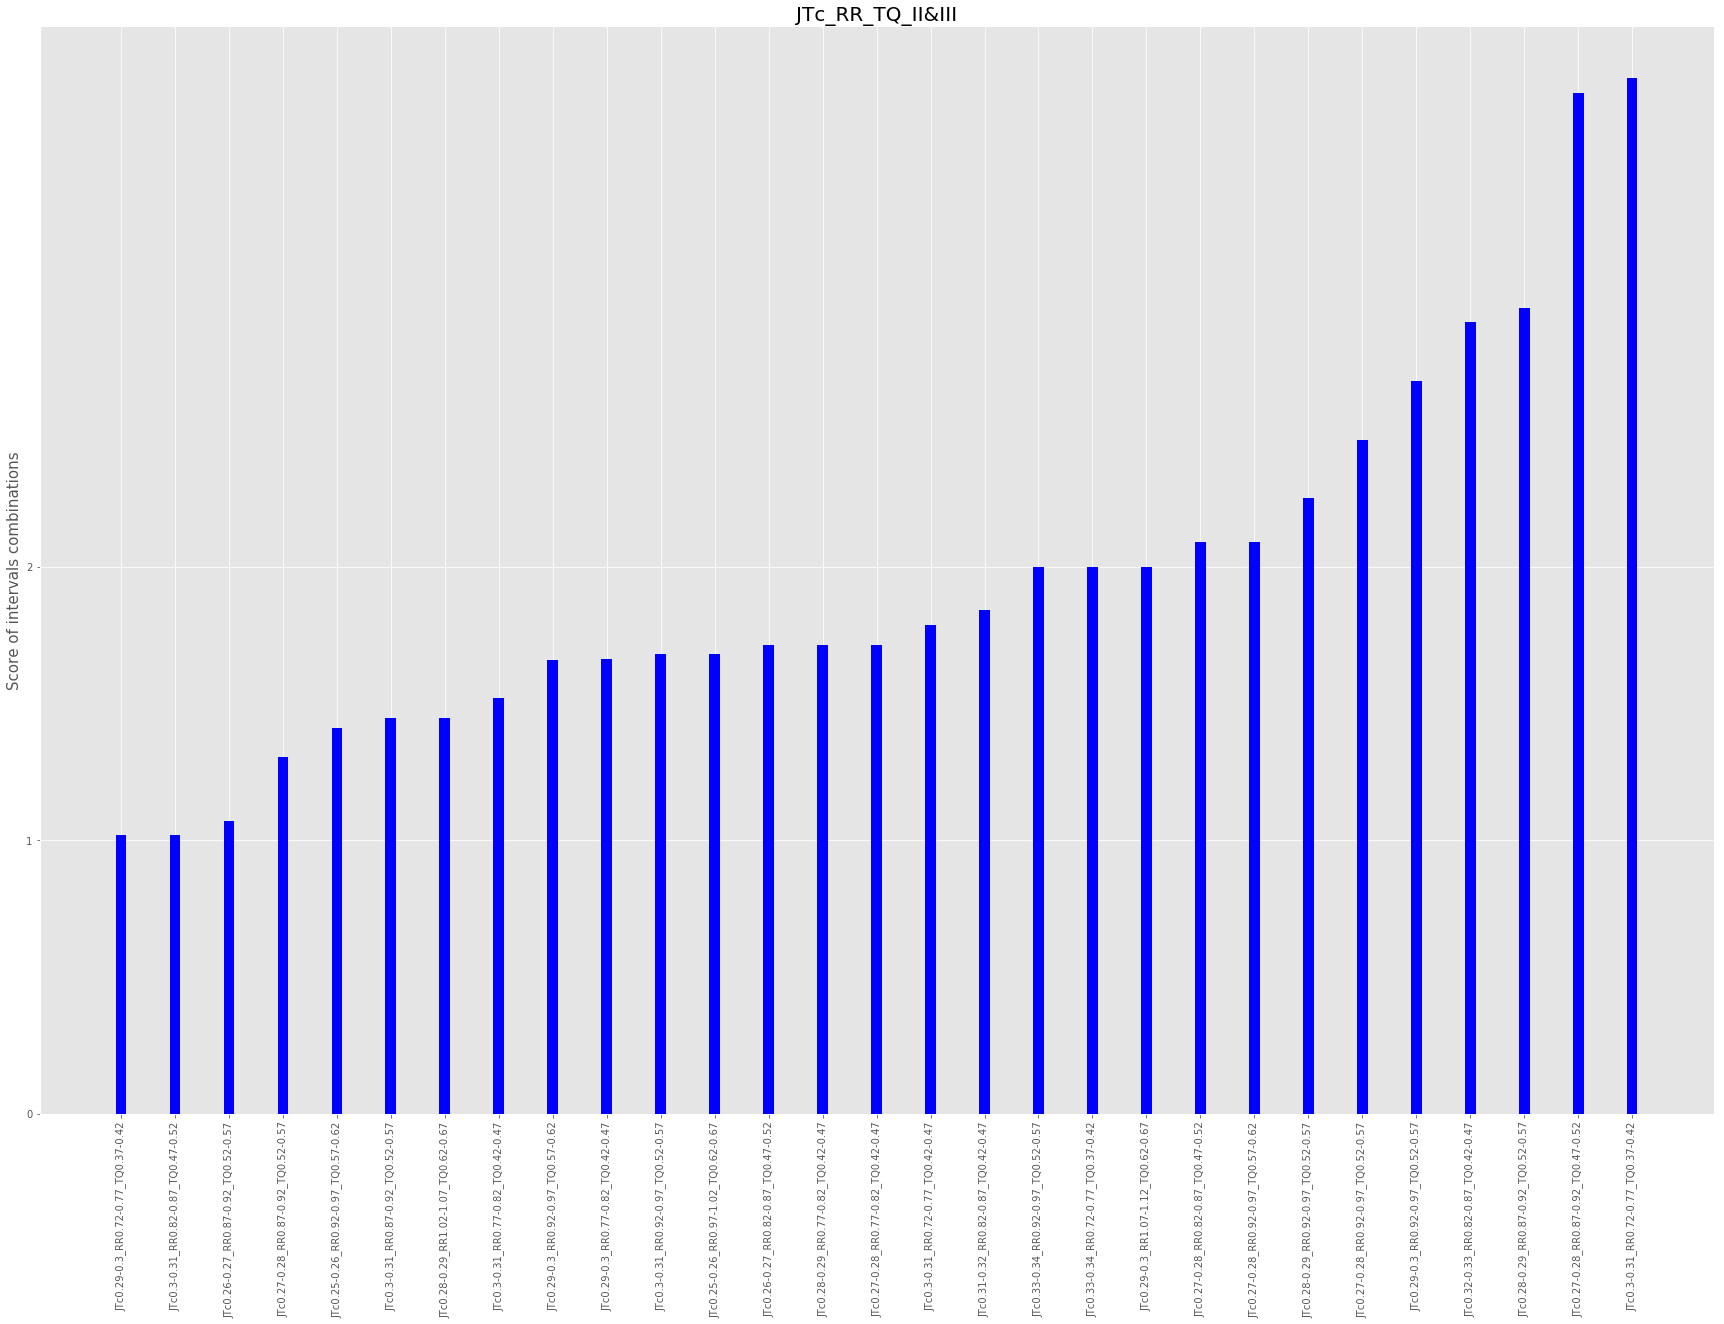

II&IIIis done
TpeakTend RR TQ
3
48


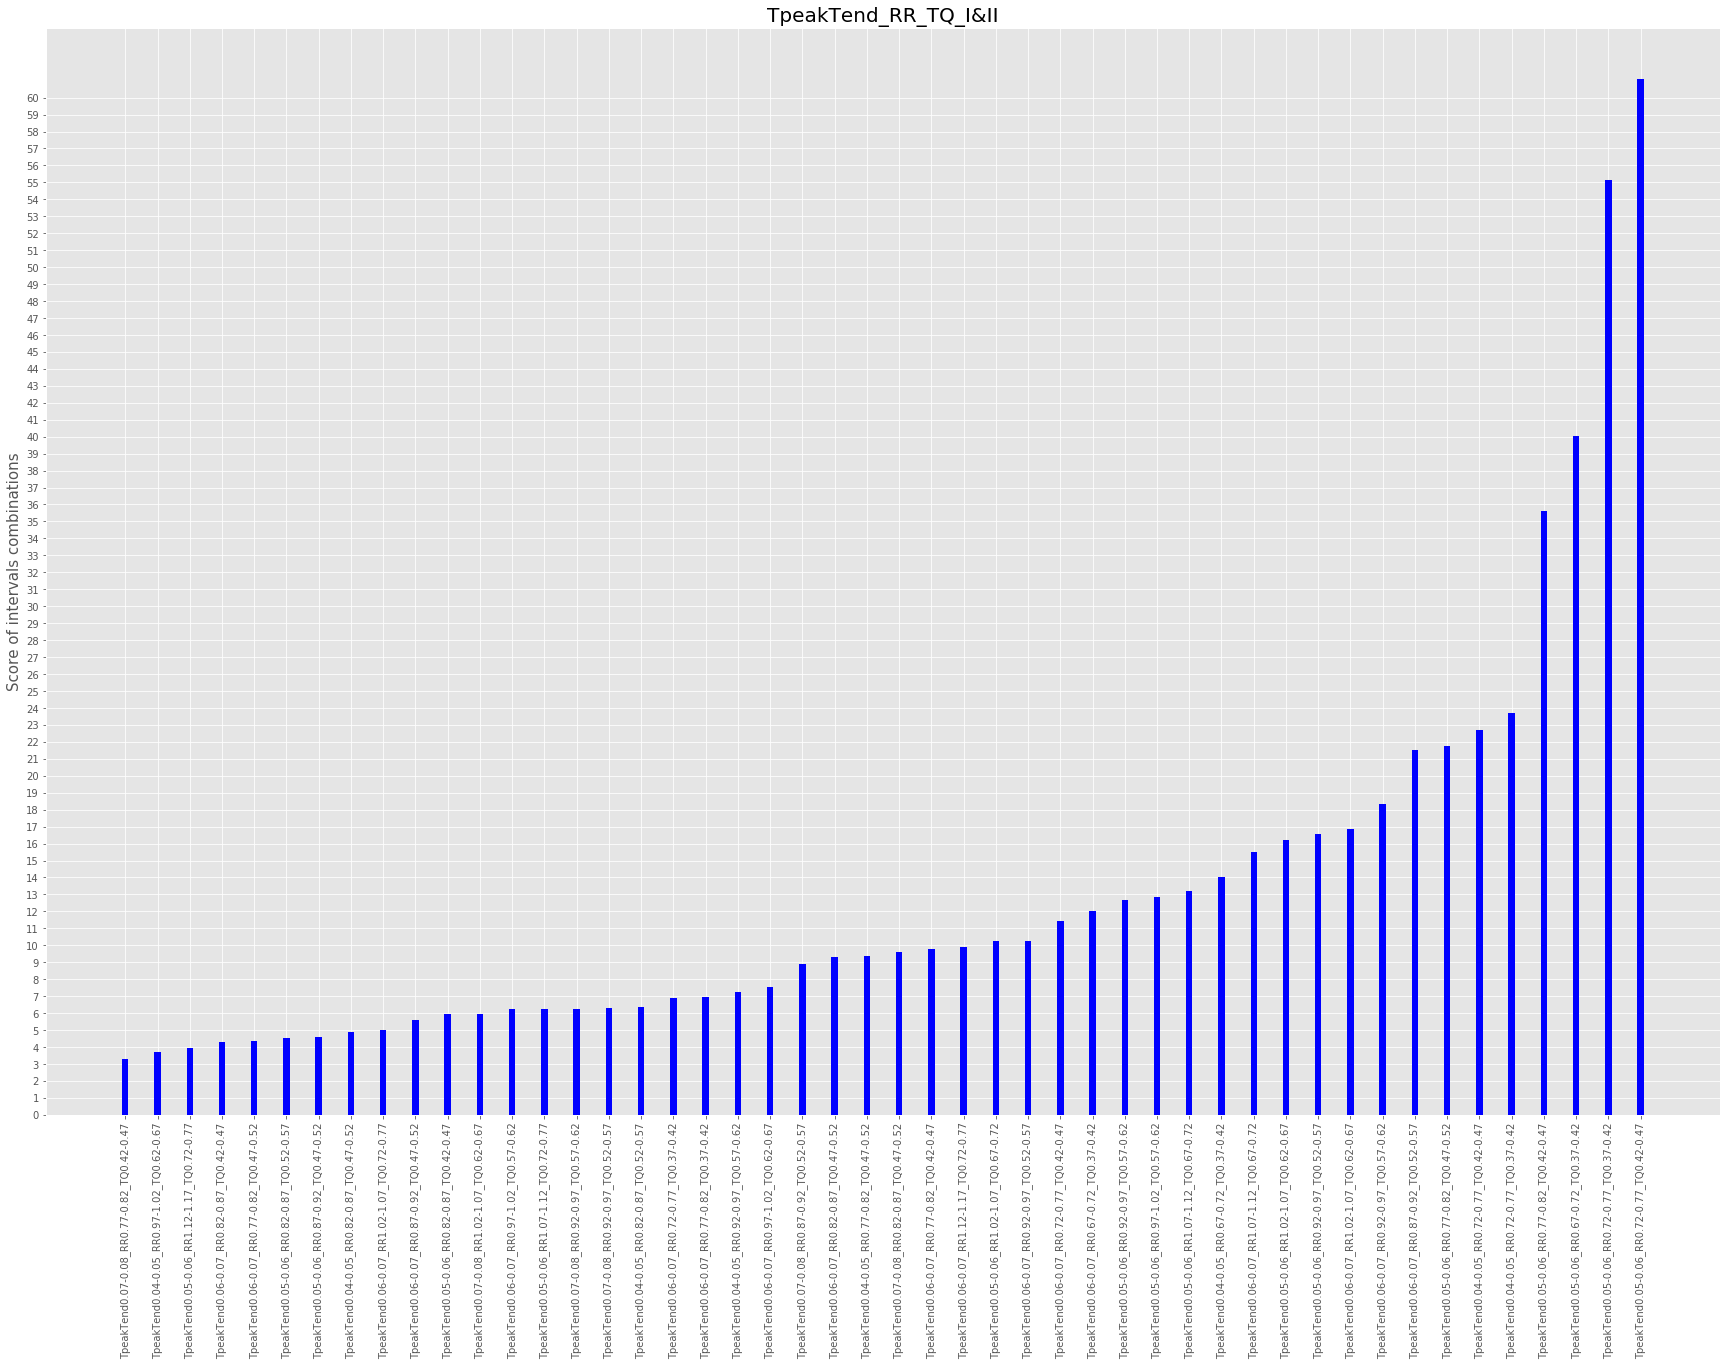

I&IIis done
9
48


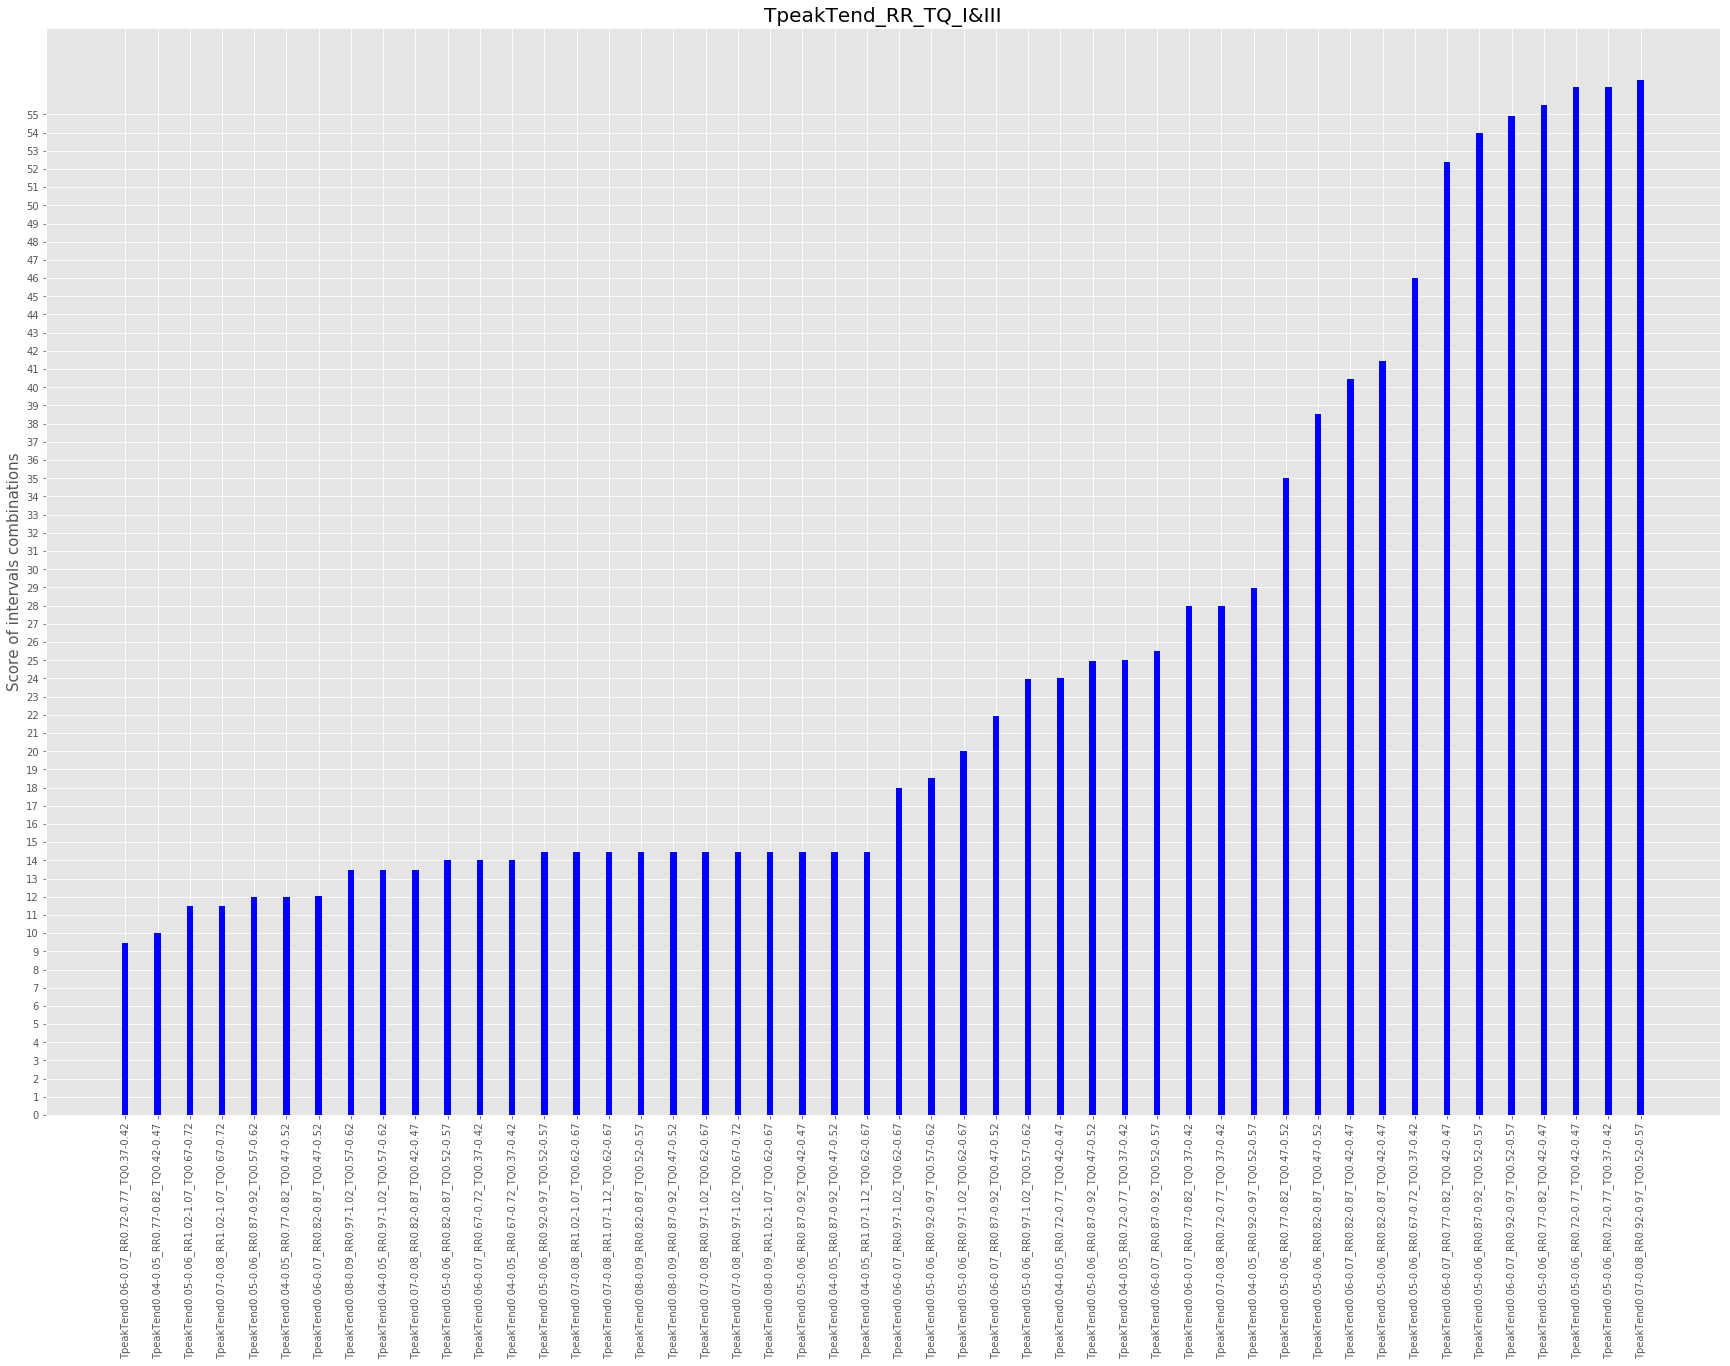

I&IIIis done
1
24


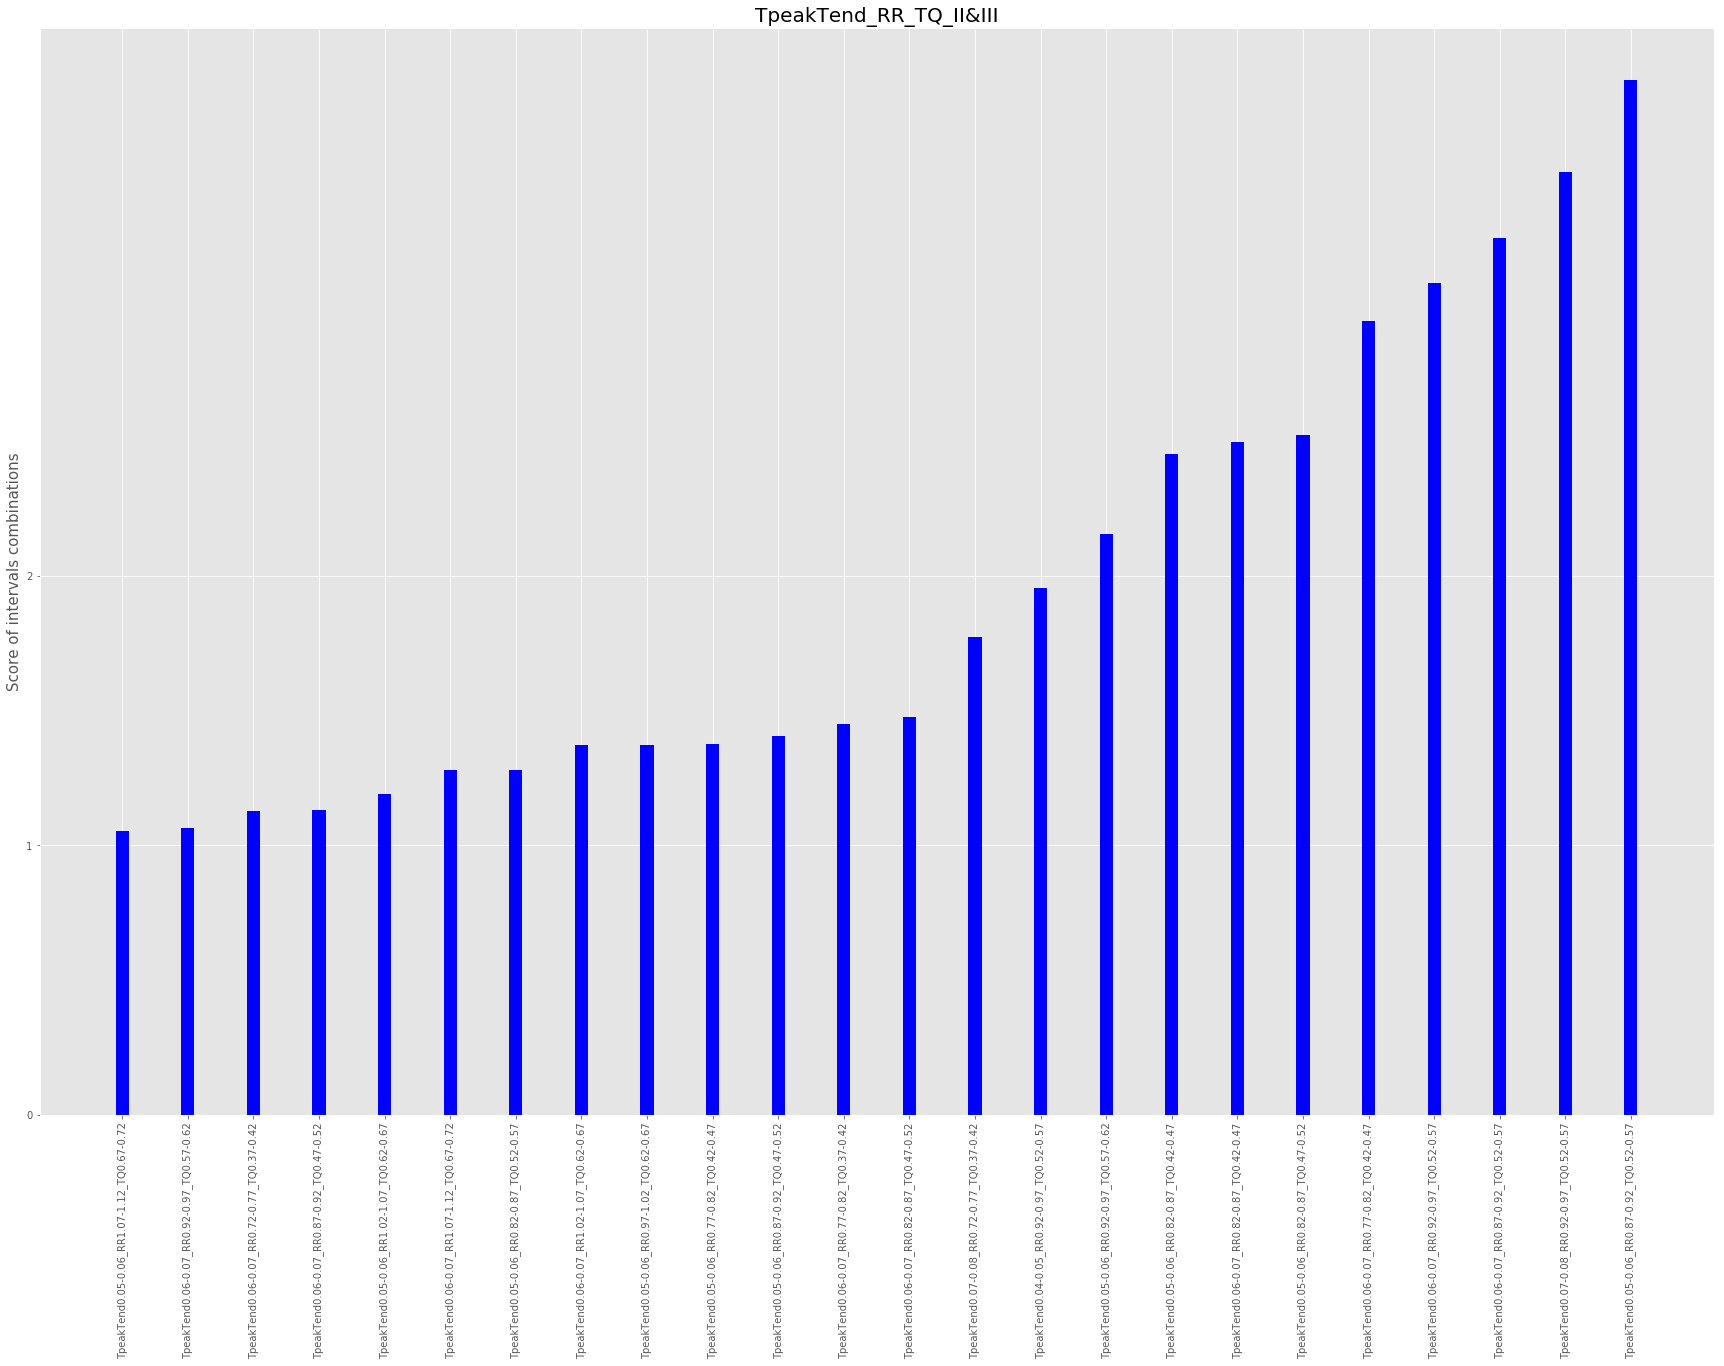

II&IIIis done
TQ TpeakTend JTc
5
46


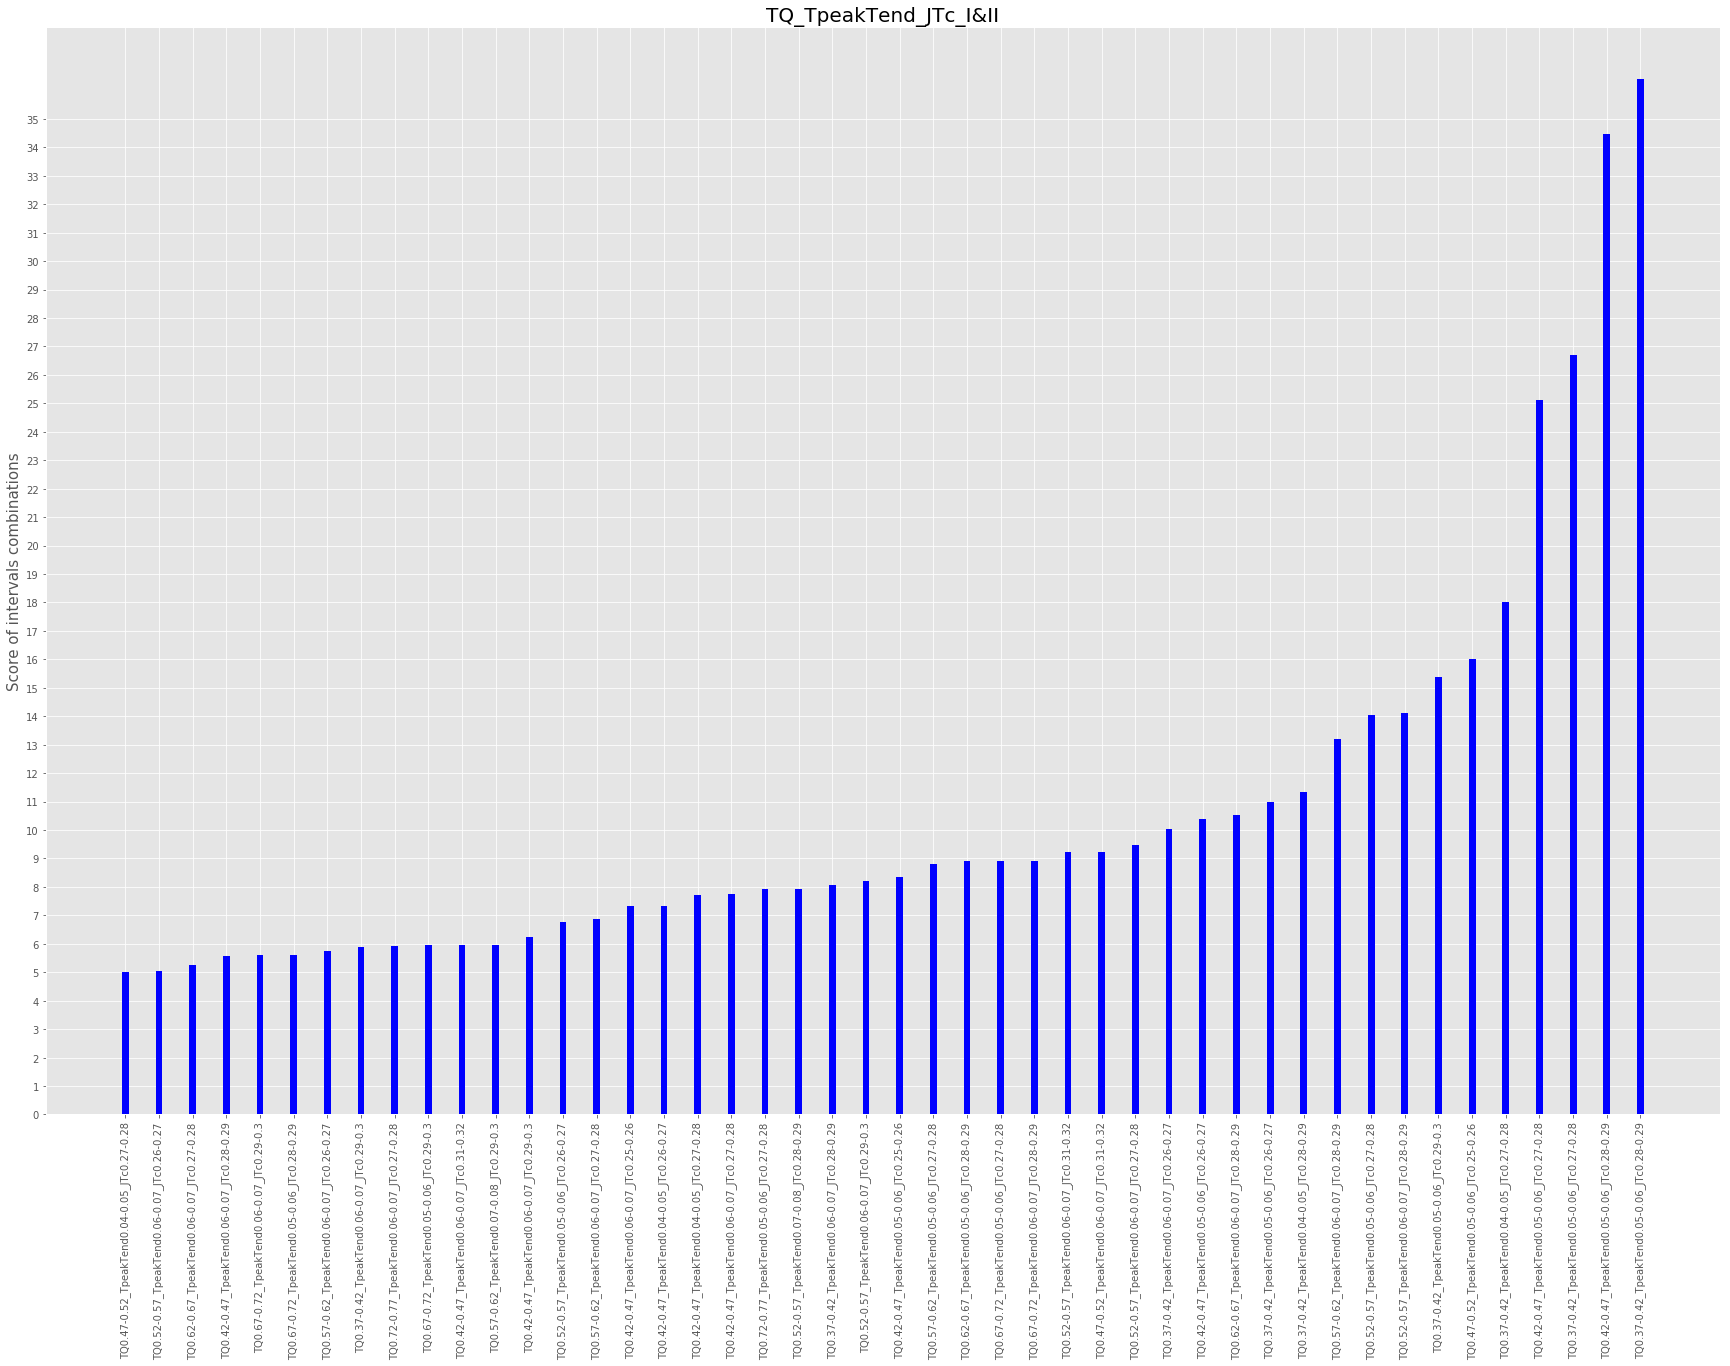

I&IIis done
13
46


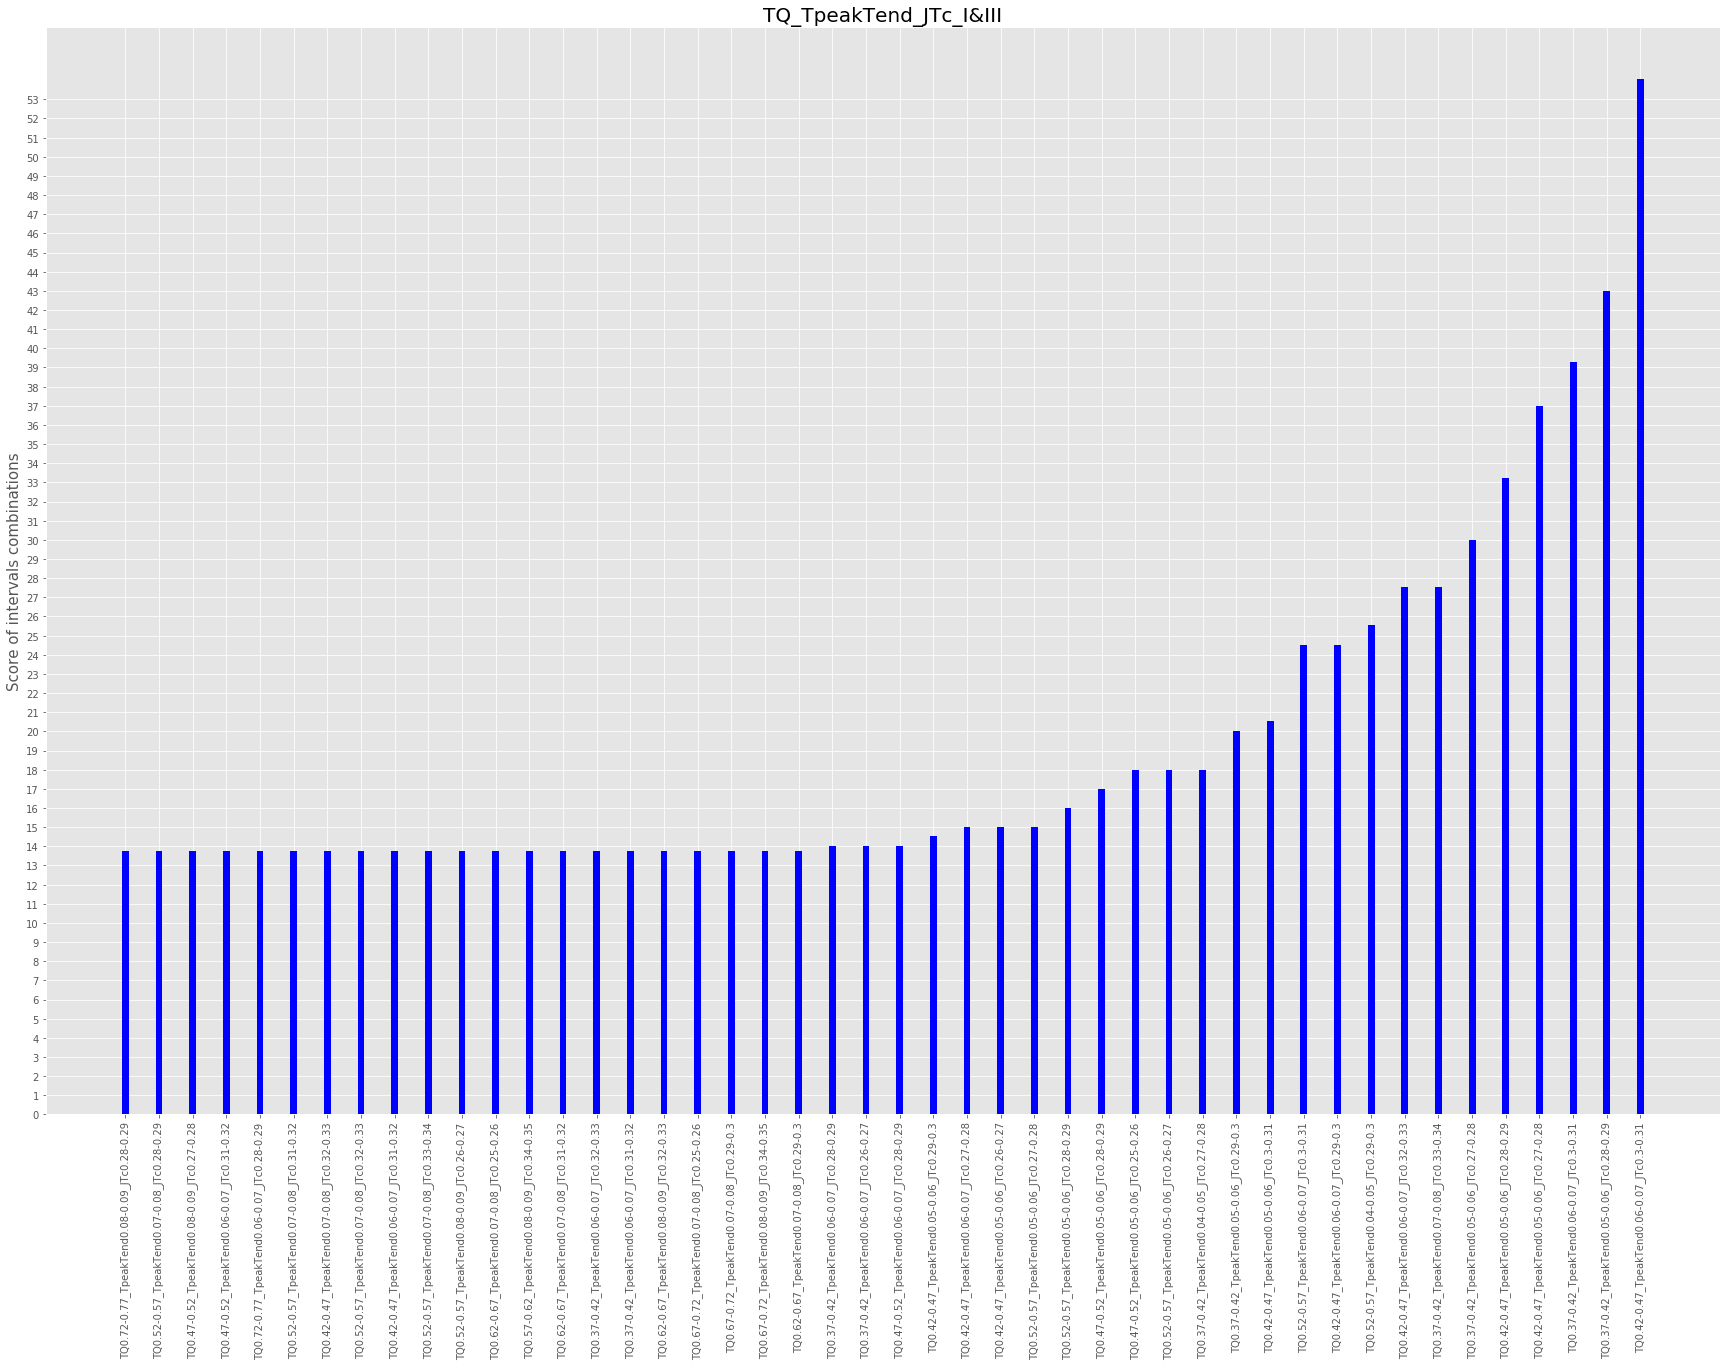

I&IIIis done
1
15


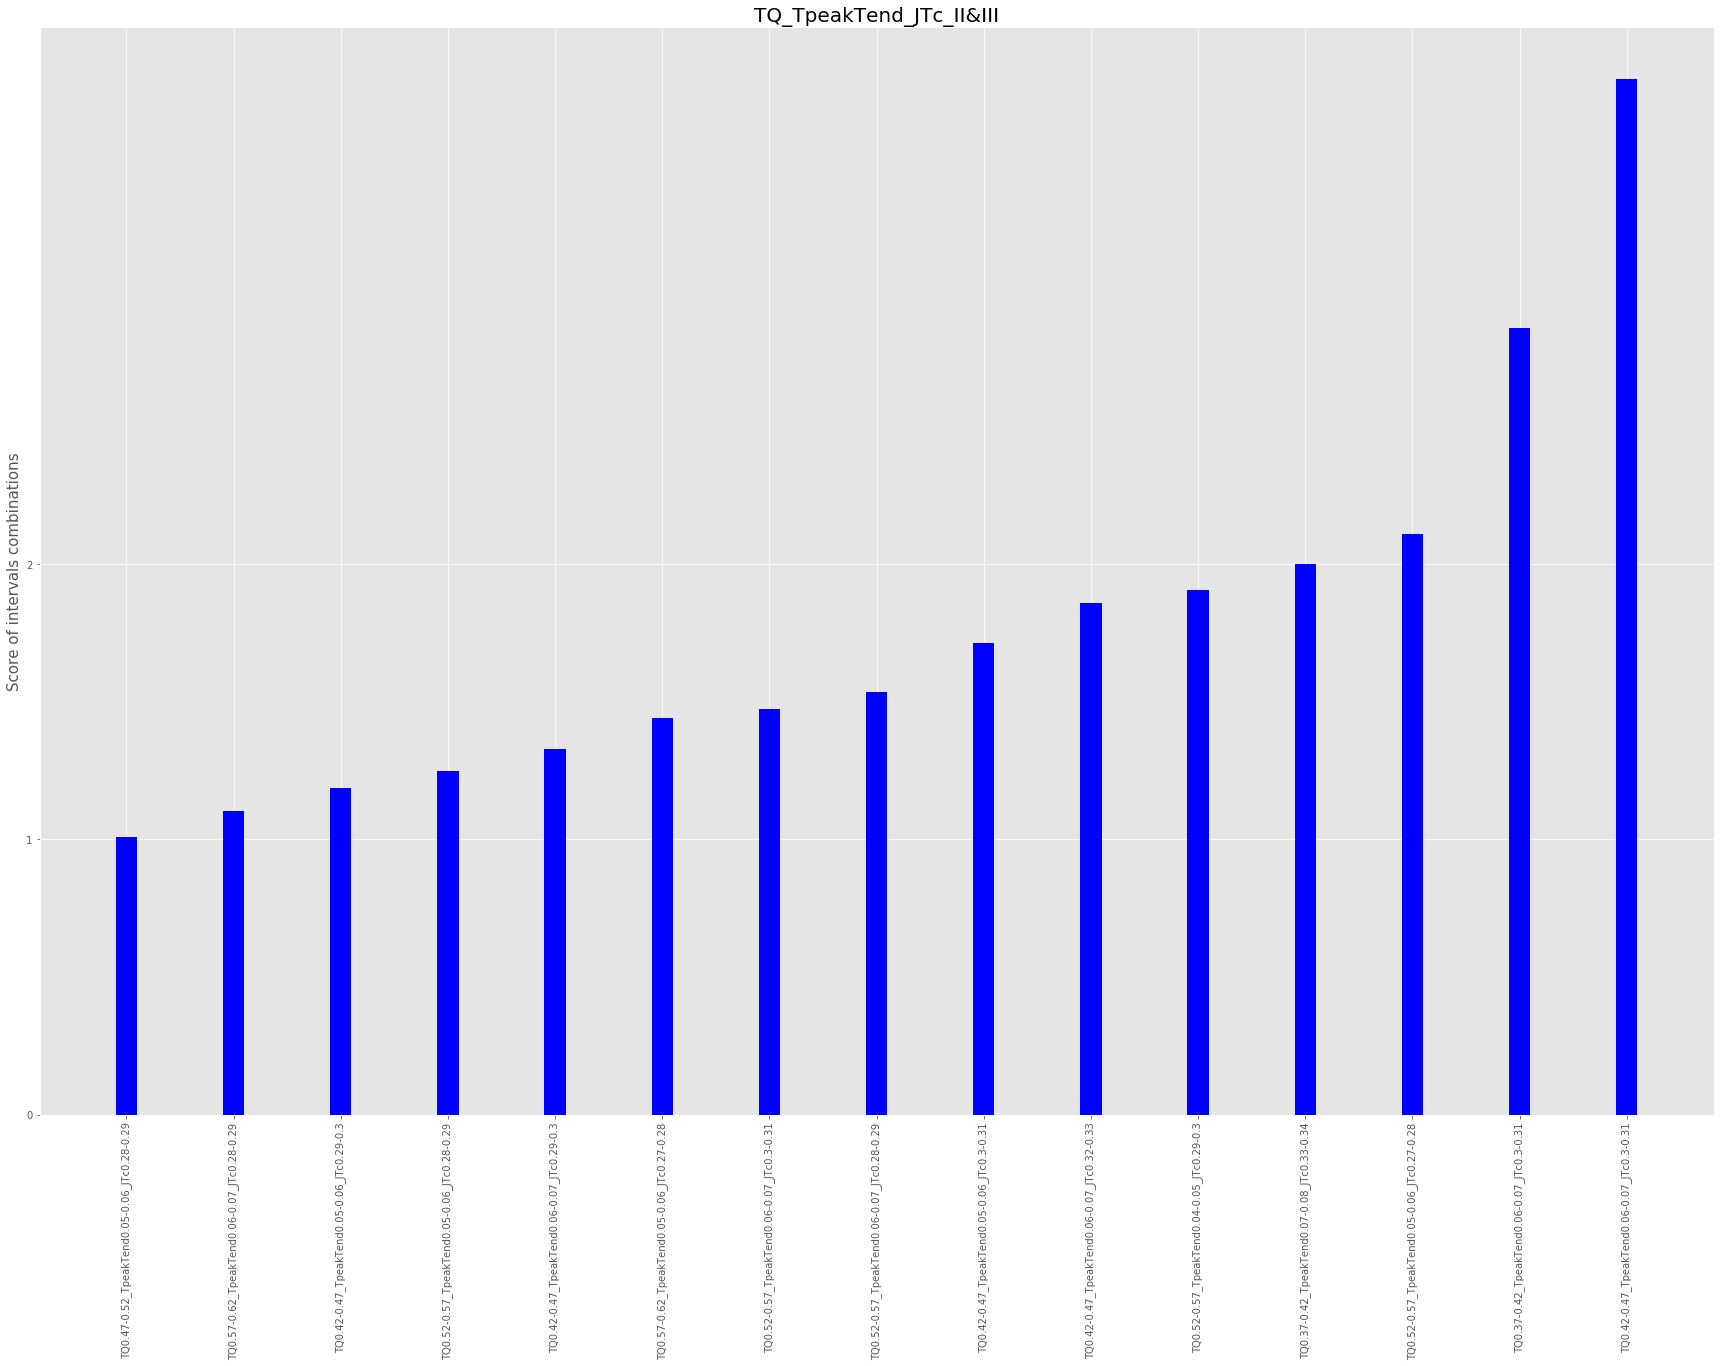

II&IIIis done


In [9]:
# features_list = [[0,2,1], [0,2,3], [0,4,2], [0,4,1], [4,2,1]]
features_list = [[0,3,1], [0,4,3], [1,4,3], [2,4,3], [3,2,1]]
forms_final_dirs_for_features_list(data_heal, data_sick, data_very_sick, 
                                   features_list, build_plots=True, build_rating=True)


In [40]:
def build_ordered_3d_intervals_plot(table_diffes, table_labels, plt_title):
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (30, 20)
    fig, ax = plt.subplots()
    plt.bar(np.arange(0, table_diffes.size), table_diffes, width=0.2, color='blue')
    plt.title(plt_title)
    ax.set_xticklabels(table_labels)
    plt.xticks(np.arange(0, table_diffes.size), rotation=90)
    plt.yticks(np.arange(int(table_diffes.max())))
    plt.ylabel('Score of intervals combinations', fontsize=15)
#     plt.savefig(plt_title, bbox_inches='tight')
    plt.show()
    plt.close()

def form_3d_intervals_rating(tables_heal, tables_sick, 
                             thresh_base, threshX, threshY, 
                             feat, featX, featY, 
                             plt_title):
    s_base=thresh_base.size-1; sX=threshX.size-1; sY=threshY.size-1    
    table_labels = []
    table_diffes = np.zeros(tables_heal.shape)
    for ii in range(s_base):
        for i in range(sX):
            for j in range(sY):
                label = plot_labels[feat_base] + tostr(thresh_base[ii])+"-"+tostr(thresh_base[ii+1])+"_"+\
                            plot_labels[featX]+tostr(threshX[i])+"-"+tostr(threshX[i+1])+"_" + \
                            plot_labels[featY]+tostr(threshY[j])+"-"+tostr(threshY[j+1])
                table_labels.append(label)
                h = tables_heal[ii,i,j]
                s = tables_sick[ii,i,j]
                if h==0 and s==0:
                    continue
                if h==0 or s==0:
                    table_diffes[ii,i,j] = h+s
                else:
                    table_diffes[ii,i,j] = float(h-s)/h+s
    table_diffes = table_diffes.reshape((-1,))
    build_ordered_3d_intervals_plot(table_diffes, table_labels, plt_title)

In [42]:
l = ["A", "B", "C"]
l[[0, 2]]

TypeError: list indices must be integers or slices, not list